In [163]:
#Functions from lesson:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline
import numpy as np
#import pickle
import cv2
from scipy.ndimage.measurements import label
import glob
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
import time
import random
import os
def load_pickle(file):
    with open(file+".pckl", mode='rb') as f:
        return pickle.load(f)
    
def save_pickle(filename,obj):
    print("saved as", filename + ".pckl")
    with open(filename+".pckl", mode='wb') as f:
        pickle.dump(obj, f)   

def convert_color(image, color_space='RGB2YCrCb',copy=False):
    if color_space != 'RGB':
        if color_space == 'HSV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    elif copy: 
        return np.copy(image)   #??   
    else:
        return image


def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=[True,False,False],
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    import sys
    # Iterate through the list of images
    
    for i,file in enumerate(imgs):
        
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'   
        feature_image = convert_color(image,color_space,True)
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            hog_features = []
            for channel in range(feature_image.shape[2]):
                if hog_channel[channel]:
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)      
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
        ss=sys.getsizeof(spatial_features)
        sh=sys.getsizeof(hist_features)
        sho=sys.getsizeof(hog_features)
        print('\r', f"ss: {ss}, sh: {sh}, sho: {sho}, it: {i} / {len(imgs)} tots: {sys.getsizeof(features)} ", end='')
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)


def confirm_car(img,svc,orient, pix_per_cell, cell_per_block,
                spatial_size, hist_bins,color_space,hog_channel,
                spatial_feat=True, hist_feat=True, hog_feat=True)

    imgs=[img]
    f=extract_features(imgs, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat):
        
        
                # Scale features and make a prediction
    test_features = X_scaler.transform(f).reshape(1, -1))    

    #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
    test_prediction = svc.predict(test_features)

    return test_prediction

        
        
     #       X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    #try:

 
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins,color_space,hog_channel,one_row=False):
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64 #Should this still be 64??
    
    #To better fit with the analyse function thing, (it shows where the start should be)
    ystop=int(ystop+window*scale)
    
    
    box_list=[]
    
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space=color_space)  
    
    imshape = ctrans_tosearch.shape
    if scale != 1:
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    #if hog_channel[0]:
    ch1 = ctrans_tosearch[:,:,0]
    if hog_channel[1]:
        ch2 = ctrans_tosearch[:,:,1]
    if hog_channel[2]:
        ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    

    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    if one_row:
        nysteps=1
    else:
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    
    if hog_channel[0]:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel[1]:
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel[2]:
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1=[]
            hog_feat2=[]
            hog_feat3=[]
            if hog_channel[0]:
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel[1]:
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel[2]:
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    

            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return box_list##draw_img, 




# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

#Add a heatmap based on the boxes
def add_heat(heatmap, bbox_list,heat=1):
    # Iterate through list of bboxes
    for box in bbox_list:
        #print(box[0][1],box[1][1], box[0][0],box[1][0])
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += heat

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

#keep just the parts where we have more than one box
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def decrease_threshold(heatmap,heat=1):
    # Zero out pixels below the threshold
    heatmap[heatmap > 0] *= heat #-= heat
    heatmap[heatmap < 0] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    all_bbox=[]
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        all_bbox.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img,all_bbox

def get_heatmap_accuracy(y_start_stop, svc, X_scaler, orient,pix_per_cell, cell_per_block, 
                         spatial_size, hist_bins,color_space,hog_channel,scale = 1.5):
    images = sorted(glob.glob('test_images/test*.jpg'))
    bimages = sorted(glob.glob('test_images/btest*.jpg'))
    totalcorr=0
    for index in range(len(images)):
        image = mpimg.imread(images[index])
        bimage = mpimg.imread(bimages[index])
        draw_image = np.copy(image)
        bimage=np.copy(bimage[:,:,0]).astype(np.float32)/255
        bimage[bimage>100]=255

        # Uncomment the following line if you extracted training
        # data from .png images (scaled 0 to 1 by mpimg) and the
        # image you are searching is a .jpg (scaled 0 to 255)
        image = image.astype(np.float32)/255
        

        hot_windows = find_cars(image, y_start_stop[0], y_start_stop[1], scale, svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space,hog_channel)

        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

        heatmap = np.zeros_like(image[:,:,0])
        heatmap = add_heat(heatmap, hot_windows)

        heatmap_img = apply_threshold(heatmap, 1)
        heatmap_binary=heatmap_img
        heatmap_binary[heatmap_binary>0]=255
        shape=np.shape(heatmap_binary)
        totalcorr+=sum(sum(heatmap_binary==bimage))/(shape[0]*shape[1])

    totalcorr/=len(images)
    return totalcorr


  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



()
data/vehicles/augmented/car13798.png


Text(0.5,1,'Not Car HOG')

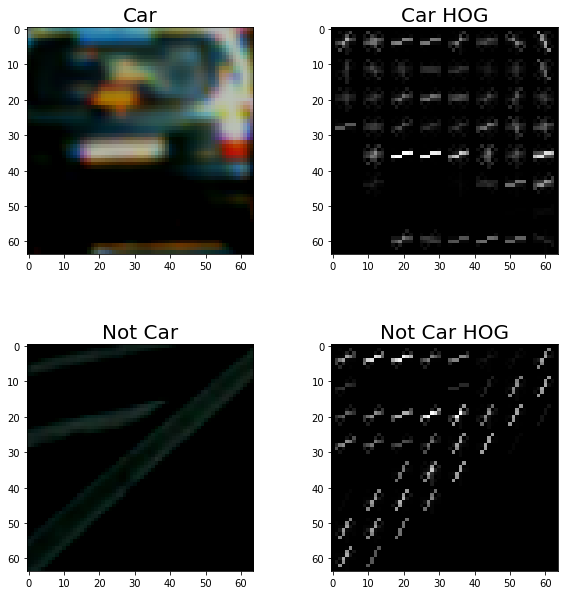

In [9]:
#Get images etc for the report
# Divide up into cars and notcars
#images = glob.glob('data/*/*/*.png')
#print(len(images))
cars = glob.glob('data/vehicles/**/*.png')
notcars = glob.glob('data/non-vehicles/**/*.png')

#for image in images:
#    if 'GTI' in image or 'Extras' in image:
#        notcars.append(image)
#    else:
#        cars.append(image)

carIndex=np.random.randint(len(cars))
notcarIndex=np.random.randint(len(notcars))
print(np.shape(cars[carIndex]))
print(cars[carIndex])

carExampleImage=mpimg.imread(cars[carIndex])
notExampleImage=mpimg.imread(notcars[notcarIndex])      

#Then some images and thier Hog features,

_, carhogimage = get_hog_features(carExampleImage[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
_, nothogimage = get_hog_features(notExampleImage[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(carExampleImage)
ax1.set_title('Car', fontsize=20)
ax2.imshow(carhogimage, cmap='gray')
ax2.set_title('Car HOG', fontsize=20)
ax3.imshow(notExampleImage)
ax3.set_title('Not Car', fontsize=20)
ax4.imshow(nothogimage, cmap='gray')
ax4.set_title('Not Car HOG', fontsize=20)

In [10]:
#Get features
#Try using a Genetic algorithm or something to find this
### TODO: Tweak these parameters and see how the results change.
        
def get_feature_and_train(color_space = 'YUV', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
                                    orient = 11,  # HOG orientations
                                    pix_per_cell = 16, # HOG pixels per cell
                                    cell_per_block = 4, # HOG cells per block
                                    hog_channel1 = False, #2#"ALL" # Can be 0, 1, 2, or "ALL"
                                    hog_channel2 = False,
                                    hog_channel3 = True,
                                    spatial_size = (16, 16), # Spatial binning dimensions
                                    hist_bins = 16,    # Number of histogram bins
                                    spatial_feat = True, # Spatial features on or off
                                    hist_feat = True, # Histogram features on or off
                                    hog_feat = True, # HOG features on or off
                                    sample_size=-1,
                                    y_start_stop = [400,660]):# Min and max in y to search in slide_window()
    print("1")                                
    cars = glob.glob('data/vehicles/**/*.png')
    notcars = glob.glob('data/non-vehicles/**/*.png')

    hog_channel = [hog_channel1,hog_channel2,hog_channel3]
    t1=time.time()
    if sample_size > 0:
        cars=np.random.choice(cars,sample_size, replace=False)
        notcars=np.random.choice(notcars,sample_size, replace=False)
    print("2")   
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    print("3")   
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    print("4")   
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    #try:
    print("5")   
    X_scaler = StandardScaler().fit(X)
    #except
    # Apply the scaler to X
    print("6")   
    scaled_X = X_scaler.transform(X)
    print("7")   
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    print("8")   
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

   # print('Using:',orient,'orientations',pix_per_cell,
   #     'pixels per cell and', cell_per_block,'cells per block')
   # print('Feature vector length:', len(X_train[0]))


    #Train classifier
    print("9")   
    # Use a linear SVC 
    svc = LinearSVC(C=1.2)
    print("10")   
    t2=time.time()
    svc.fit(X_train, y_train)
    t3 = time.time()
    total_time=t3-t1
    print("11")   
    #print(round(total_time, 2), " to run all")
    #print(round(t3-t2, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    score=svc.score(X_test, y_test)
    heat_score=get_heatmap_accuracy(y_start_stop, svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space,hog_channel)
    #print('Test Accuracy of SVC = ', round(score, 4))
    #print("heatmap accuracy: ", heat_score)
    # Check the prediction time for a single sample
    t=time.time()
    return svc,X_scaler, score, heat_score ,total_time, t3-t2

In [ ]:



    # Check the training time for the SVC
    #t2=time.time()
    #svc.fit(X_train, y_train)
    #t3 = time.time()
    #total_time=t3-t1
    #print(round(total_time, 2), " to run all")
    #print(round(t3-t2, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    #score=svc.score(X_test, y_test)
    #heat_score=get_heatmap_accuracy(y_start_stop, svc, X_scaler, orient, 
    #                  pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space,hog_channel)
    #print('Test Accuracy of SVC = ', round(score, 4))
    #print("heatmap accuracy: ", heat_score)
    # Check the prediction time for a single sample
    #t=time.time()
    #return score, heat_score ,total_time, t3-t2

table=[]
row=["color_space","orient","pix_per_cell","cell_per_block","hog1","hog2","hog3",
     "spatial_size","spatial_feat","hist_feat","hog_feat","score","heat_score","mean","train_time","total_time"]
table.append(row)

color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 4 # HOG cells per block
hog_channel1 = False #2#"ALL" # Can be 0, 1, 2, or "ALL"
hog_channel2 = False
hog_channel3 = True
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400,660]
sample_size=2000
for color_space in ['HSV','YUV','HLS']:
    for orient in [11,12]:
        for pix_per_cell in [12,16]:
            for cell_per_block in [2,4]:
                for hist_bins in [16,20]:
                    for hog_channel1 in [False,True]:
                        for hog_channel2 in [False,True]:
                            for hog_channel3 in [False,True]:
                                _,_,score, heat_score ,total_time,train_time=get_feature_and_train(color_space, orient,  pix_per_cell,cell_per_block, hog_channel1,hog_channel2,
                                            hog_channel3,spatial_size,  hist_bins, spatial_feat,hist_feat, hog_feat,sample_size)
                                row=[color_space,orient,pix_per_cell,cell_per_block,hog_channel1,hog_channel2,hog_channel3,
                                     spatial_size,spatial_feat,hist_feat,hog_feat,round(score, 4),round(heat_score, 4),
                                     round((score+heat_score)/2, 4),round(train_time, 4),round(total_time, 4)]
                                table.append(row)
                    print("hog done")

    print("color done")

from IPython.display import HTML, display
import tabulate

display(HTML(tabulate.tabulate(table, tablefmt='html')))

In [ ]:
#Train with good parameters we found above!

color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel1 = True #2#"ALL" # Can be 0, 1, 2, or "ALL"
hog_channel2 = True
hog_channel3 = True
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400,660]

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 4 # HOG pixels per cell
cell_per_block = 4 # HOG cells per block
#hog_channel1 = True #2#"ALL" # Can be 0, 1, 2, or "ALL"
#hog_channel2 = True
#hog_channel3 = True
#spatial_size = (32, 32) # Spatial binning dimensions
#hist_bins = 16    # Number of histogram bins
#spatial_feat = True # Spatial features on or off
#hist_feat = True # Histogram features on or off
#hog_feat = True # HOG features on or off

#        colorspace='YCrBr',
#        orient=9,
#        pix_per_cell=4, 
#        cell_per_block=4, 
#        hog_channel='ALL',
#        spatial_size=(32, 32),
#        hist_bins=32,
#        spatial_feat=True,
#        hist_feat=True,
#        hog_feat=True
svc,X_scaler,score, heat_score ,total_time,train_time=get_feature_and_train(color_space, orient, pix_per_cell,
                                    cell_per_block, hog_channel1,hog_channel2, hog_channel3,spatial_size, 
                                    hist_bins, spatial_feat,hist_feat, hog_feat,sample_size=-1)
#Now svc is a great model, so save it
print(f"score: {score}, heat score: {heat_score}, tot time: {total_time}, train time: {train_time}")


            
            
save_pickle("model_ycrbr",{"svc":svc,
                     "X_scaler":X_scaler,
                     "orient":orient,
                     "pix_per_cell":pix_per_cell,
                     "cell_per_block":cell_per_block,
                     "spatial_size":spatial_size,
                     "hist_bins":hist_bins,
                     "hog_channel":[hog_channel1,hog_channel2,hog_channel3],
                    "color_space":color_space
                    })

1
2
 ss: 96, sh: 480, sho: 96, it: 10064 / 27760 tots: 87624 

96.0
96
96
96
96
96
96
96
96
96
96
96
96
96
96


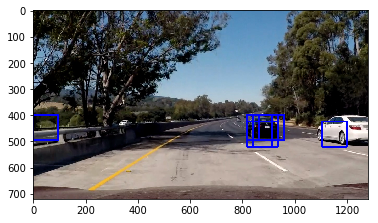

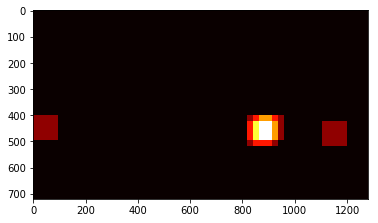

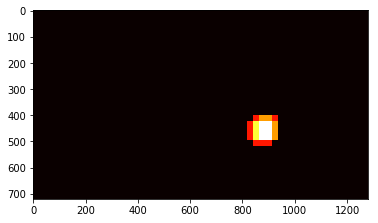

0.960684678819


In [2]:
#try the classifier with just images before video
images = sorted(glob.glob('test_images/test*.jpg'))
%matplotlib inline
index=np.random.randint(len(images))
image = mpimg.imread(images[index])

draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255
y_start_stop = [400,660]
scale = 1.5



dist_pickle=load_pickle("model")
svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
hog_channel = dist_pickle["hog_channel"]
color_space = dist_pickle["color_space"]
scale = 1.5
print(64*scale)
hot_windows = find_cars(image, y_start_stop[0], y_start_stop[1], scale, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space,hog_channel)

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
for window in hot_windows:
    print(window[1][0]-window[0][0])
    print(window[1][1]-window[0][1])
plt.imshow(window_img)
plt.show()
#Do the heatmap stuff
heatmap = np.zeros_like(image[:,:,0])
heatmap = add_heat(heatmap, hot_windows)
plt.imshow(heatmap, cmap='hot')
plt.show()
heatmap_img = apply_threshold(heatmap, 1)

plt.imshow(heatmap_img, cmap='hot')
plt.show()



bimages = sorted(glob.glob('test_images/btest*.jpg'))
bimage = mpimg.imread(bimages[index])
draw_image = np.copy(image)
bimage=np.copy(bimage[:,:,0]).astype(np.float32)/255
bimage[bimage>100]=255
heatmap_binary=heatmap_img
heatmap_binary[heatmap_binary>0]=255
shape=np.shape(heatmap_binary)
print(sum(sum(heatmap_binary==bimage))/(shape[0]*shape[1]))

  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



1.0
1.5
2.0
2.5
[ 300.  350.  400.  450.  500.  550.  600.  650.  300.  350.  400.  450.
  500.  550.  600.  300.  350.  400.  450.  500.  550.]
[ 1.   1.   1.   1.   1.   1.   1.   1.   1.5  1.5  1.5  1.5  1.5  1.5  1.5
  2.   2.   2.   2.   2.   2. ]
[ 0.          0.          0.13684516  0.06448347  0.          0.          0.
  0.          0.          0.          0.55404065  0.09978187  0.          0.
  0.          0.          0.          0.39990629  0.          0.          0.        ]


start,scale,match,false,boxes,time
300,1.0,0.0,0.0,0,3.087430477142334
350,1.0,0.0,0.0,0,5.605781078338623
400,1.0,0.13684515812649203,0.013209909960979744,6,7.86411190032959
450,1.0,0.06448347192803078,0.0032469067881950833,2,9.77288031578064
500,1.0,0.0,0.0,0,11.403167247772217
550,1.0,0.0,0.0,0,12.792498588562012
600,1.0,0.0,0.0,0,13.972275018692017
650,1.0,0.0,0.008333333333333333,1,14.843976736068726
300,1.5,0.0,0.012499999999999999,1,1.4767813682556152
350,1.5,0.0,0.06559700873536704,5,2.8169989585876465


saved as scaletable1.pckl


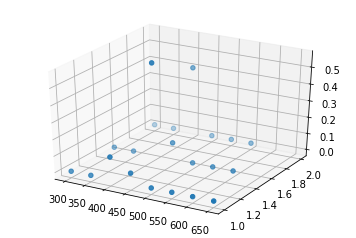

In [12]:
#try the classifier with just images before video
images = sorted(glob.glob('test_images/test*.jpg'))


dist_pickle=load_pickle("model")
svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
hog_channel = dist_pickle["hog_channel"]
color_space = dist_pickle["color_space"]



#draw_image = np.copy(image)
bimages = sorted(glob.glob('test_images/btest*.jpg'))
bimagesimages=[]
for imgpath in bimages:
    bimage = mpimg.imread(imgpath)
    bimage=np.copy(bimage[:,:,0]).astype(np.float32)/255
    bimage[bimage>100]=255
    bimagesimages.append(bimage)

ylen = bimagesimages[0].shape[0]  
table=[]
table.append(["start","scale","match","false","boxes","time"])
for scale in np.arange(1,3,0.5):
    t1 = time.time()
    print(scale)
    #ystart=random.randint(300,ylen-100)
    
    #scale = random.uniform(0.5,2)
    
    for ystart in range(300,ylen,50):
        y_start_stop = [ystart,ylen]
        
        nWindows=0
        heatscore=0
        heatscorefalse=0
        bflag=False
        for i, image_a in enumerate(images):
            image =  mpimg.imread(image_a).astype(np.float32)/255
            bimage=bimagesimages[i]
            try:
                hot_windows = find_cars(image, y_start_stop[0], y_start_stop[1], scale, svc, X_scaler, orient, 
                          pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space,hog_channel,one_row=True)
            except:
                bflag=True
                break
            heatmap = np.zeros_like(image[:,:,0])
            heatmap = add_heat(heatmap, hot_windows)
            heatmap[heatmap>0]=255
            shape=np.shape(heatmap)
            #how much of what we want is good
            truehotindexes = np.array(bimage[y_start_stop[0]:y_start_stop[0]+int(64*scale),:]>0)
            hotindexes = np.array(heatmap[y_start_stop[0]:y_start_stop[0]+int(64*scale),:]>0)
            deno =(sum(sum(truehotindexes)))
            if deno!=0:
                heatscore += sum(sum(truehotindexes&hotindexes))/deno
            #how much false positive?
            heatscorefalse += sum(sum(np.logical_not(truehotindexes)&hotindexes))/(sum(sum(np.logical_not(truehotindexes))))
            t2 = time.time()
            total_time=t2-t1
            nWindows += len(hot_windows)
        if bflag:
            break
        #if nWindows > 0:
        heatscore/=len(images)
        heatscorefalse/=len(images)
        table.append([y_start_stop[0],scale,heatscore,heatscorefalse,nWindows,total_time])

#window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
from mpl_toolkits.mplot3d import Axes3D
import scipy.linalg
Xdata=np.array(table)[1:,0].astype(float)
print(Xdata)
Ydata=np.array(table)[1:,1].astype(float)
print(Ydata)
Zdata=np.array(table)[1:,2].astype(float)
print(Zdata)
#data=np.array((Xdata,Ydata,Zdata))
#print(data)

#X,Y = np.meshgrid(np.unique(X), np.unique(Y))

#XX = X.flatten()
#YY = Y.flatten()
# best-fit quadratic curve
#A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
#C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])

# evaluate it on a grid
#Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.scatter(Xdata, Ydata,Zdata)

from IPython.display import HTML, display
import tabulate

display(HTML(tabulate.tabulate(table, tablefmt='html')))
save_pickle("scaletable1",{"table":table})

[ 300.  305.  310. ...,  460.  465.  470.]
[ 0.2  0.2  0.2 ...,  3.9  3.9  3.9]
[ 0.  0.  0. ...,  0.  0.  0.]
[ 0.04153646  0.040625    0.02981771 ...,  0.06817946  0.          0.03370001]


<IPython.core.display.Javascript object>


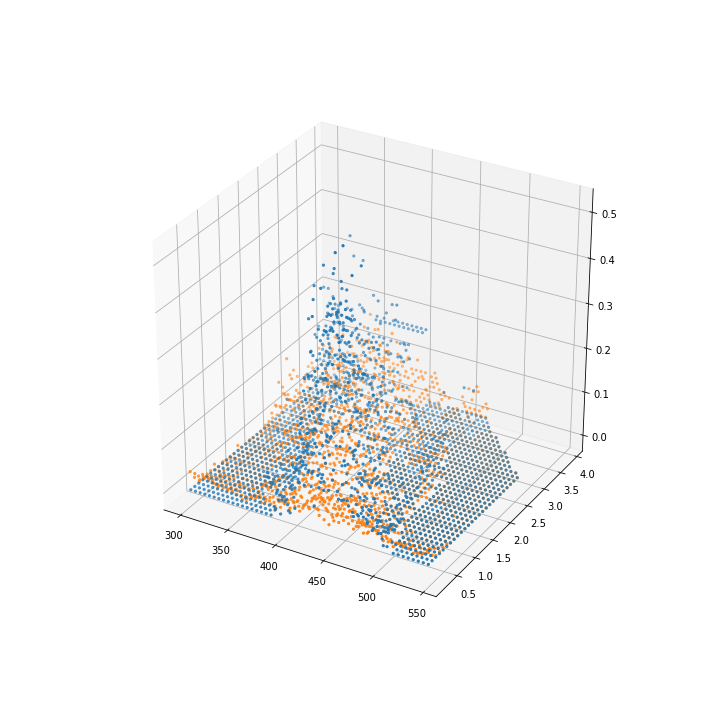

In [10]:
#%matplotlib notebook
table=load_pickle("scaletable")
table=table["table"]
from mpl_toolkits.mplot3d import Axes3D
Xdata=np.array(table)[1:,0].astype(float)
print(Xdata)
Ydata=np.array(table)[1:,1].astype(float)
print(Ydata)
Zdata=np.array(table)[1:,2].astype(float)
print(Zdata)
Zdata2=np.array(table)[1:,3].astype(float)
print(Zdata2)

%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
surf = ax.scatter(Xdata, Ydata,Zdata,s=5)
surf2 = ax.scatter(Xdata, Ydata,Zdata2,s=5)

<IPython.core.display.Javascript object>


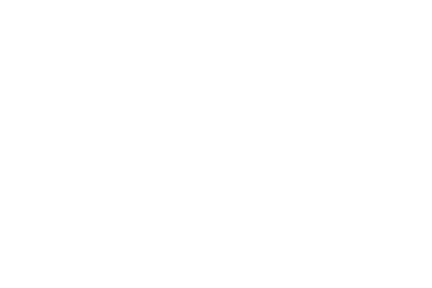

<IPython.core.display.Javascript object>


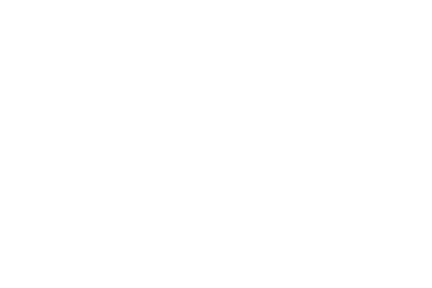

In [185]:
from matplotlib.mlab import griddata
xi = np.linspace(Xdata.min()-10, Xdata.max()+10, 1000)
yi = np.linspace(Ydata.min()-1, Ydata.max()-1, 1000)
zi = griddata(Xdata, Ydata, Zdata, xi, yi, interp='linear')
%matplotlib notebook
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(xi, yi,zi)


In [12]:
import numpy as np
from mayavi import mlab

X = np.array([0, 1, 0, 1, 0.75])
Y = np.array([0, 0, 1, 1, 0.75])
Z = np.array([1, 1, 1, 1, 2])

# Define the points in 3D space
# including color code based on Z coordinate.
pts = mlab.points3d(X, Y, Z, Z)

# Triangulate based on X, Y with Delaunay 2D algorithm.
# Save resulting triangulation.
mesh = mlab.pipeline.delaunay2d(pts)

# Remove the point representation from the plot
pts.remove()

# Draw a surface based on the triangulation
surf = mlab.pipeline.surface(mesh)

# Simple plot.
mlab.xlabel("x")
mlab.ylabel("y")
mlab.zlabel("z")
mlab.show()

ModuleNotFoundError: No module named 'mayavi2'

In [156]:
def add_text(img, strings):
    for i, string in enumerate(strings):
        cv2.putText(img, string,(50,50+i*50),cv2.FONT_HERSHEY_COMPLEX,0.5,(255,255,255),2)
    return img

def process_image(input_image,dist_pickle,heatmap,car_tracker,cnt):
    t1 = time.time()
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["X_scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    hog_channel = dist_pickle["hog_channel"]
    color_space = dist_pickle["color_space"]
    #find hot windows:
    y_start_stop = [350,450]
    hot_windows = []
    t2 = time.time()
    for i,scale in enumerate([0.8,1,1.2,1.3,1.4,1.5,1.6]):
        hw=find_cars(input_image, y_start_stop[0], y_start_stop[1], scale, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space,hog_channel)
        if hw:
            #cnt[i]+= len(hw)
            #print(cnt)
            hot_windows.append(hw)
    t3 = time.time()
    if hot_windows:
        hot_windows=np.concatenate(hot_windows)
    heatmap = add_heat(heatmap, hot_windows,2)
    deno=sum(sum(heatmap))/(heatmap.shape[0]*heatmap.shape[1])
    #print(deno)
    if deno>0:
        heatmap = decrease_threshold(heatmap,3/deno) #This will decay the heatmap
    heatmap_img = apply_threshold(np.copy(heatmap),50)
    #output_img = draw_boxes(input_image, hot_windows, color=(0, 0, 255), thick=6) 
    x_offset=800
    y_offset=100
    #heatmap = np.zeros_like(image[:,:,0])
    labels = label(heatmap_img)
    
    t4 = time.time()
    result_image, all_bbox = draw_labeled_bboxes(np.copy(input_image), labels)
    
    car_tracker.reduce_car_p()
    for bbox in all_bbox:
        car_tracker.update_cars(bbox)
    t5 = time.time()
    car_boxes = car_tracker.get_car_boxes()
    #result_image=draw_boxes(result_image, car_boxes, color=(255, 255, 255), thick=6)
    for box in car_boxes:
        cv2.circle(result_image, (int(box[0][0]),int(box[0][1])), int(box[1]), color=(255, 255, 255))
    t6 = time.time()
    tmp = cv2.cvtColor(heatmap, cv2.COLOR_GRAY2RGB)
    binary_image = cv2.resize(tmp, (400,200))
    result_image[y_offset:y_offset+200, x_offset:x_offset+400] = binary_image
    t7 = time.time()
    #add text:
    result_image=add_text(result_image, car_tracker.get_text())
    print(f"t7 {t7-t6} t6 {t6-t5} t5 {t5-t4} t4 {t4-t3} t3 {t3-t2} t2 {t2-t1}")
    return result_image

In [159]:
class carTracker:
    def __init__(self):
        #print("intit track")
        self.tot_item_found=0
        self.current_car_count=0
        self.cars={}
    
    class car:
        def __init__(self,new_id,bbox):
            #print("initcar")
            
            # size is the avrage distance to borders
            
            self.id=new_id
            self.pos=((bbox[1][0]+bbox[0][0])/2,(bbox[1][1]+bbox[0][1])/2)
            self.size=((bbox[1][0]-bbox[0][0]+bbox[1][1]-bbox[0][1])/2)
            self.carbox=bbox
            self.probability=0.2 #probability it really is a car
            self.rel_speed=(0,0)
            self.alive_frame_counter=0
            self.car_taken=True
            
        def update(self,bbox):
            
            newpos=((bbox[1][0]+bbox[0][0])/2,(bbox[1][1]+bbox[0][1])/2)
            dist=(newpos[0]-self.pos[0],newpos[1]-self.pos[1])
            phi=0.8
            self.rel_speed=(self.rel_speed[0]*phi+dist[0]*(1-phi),
                            self.rel_speed[1]*phi+dist[1]*(1-phi))#avg.pixels per frame 
            #todo add size!
            self.pos=((bbox[1][0]+bbox[0][0])/2,(bbox[1][1]+bbox[0][1])/2)
            self.alive_frame_counter+=1
            self.probability+=0.2
            #print(f"hi, my name is {self.id}. speed: {self.rel_speed} , pos {self.pos}"+
            #      f"Iam {self. alive_frame_counter} frames old, and my probs is {self.probability}")
            if self.probability >= 1:
                self.probability=1
        
        def who_are_you_mr_car(self):
            return (f"hi, my name is {self.id}. speed: {self.rel_speed} , pos {self.pos}"+
                  f"Iam {self. alive_frame_counter} frames old, and my probs is {self.probability}")
        
        def update_pos(self):
            self.pos=(self.pos[0]+self.rel_speed[0],self.pos[1]+self.rel_speed[1])
            #self.carbox[0][0]+=self.rel_speed[0]
            #self.carbox[1][0]+=self.rel_speed[0]
            #self.carbox[0][1]+=self.rel_speed[1]
            #self.carbox[1][1]+=self.rel_speed[1]
            
    def add_car(self,bbox):
        # pos is in (x,y)
        
        #print(bbox)
        self.tot_item_found +=1
        new_id= self.tot_item_found
        #print(f"new car {new_id}")
        self.cars[new_id]=self.car(new_id, bbox)
        
    def reduce_car_p(self):
        #This will do more than just reduce p
        delete_items=[]
        for carid, data in self.cars.items():
            data.probability-=0.1
            if data.probability <= 0:
                delete_items.append(carid)
            data.update_pos()
            data.car_taken=False
        for carid in delete_items:
            #print(f"delete {self.cars[carid].id}")
            del self.cars[carid]
            
    def update_cars(self,bbox):
        #print("get car")
        '''Returns all car candidates in the box with a distance'''
        #found_cars=[]
        best_car=None
        best_car_dist=10000000
        bboxpos=((bbox[1][0]+bbox[0][0])/2,(bbox[1][1]+bbox[0][1])/2)
        #size=((bbox[1][0]-bbox[0][0]+bbox[1][1]-bbox[0][1])/2)
        for carid, data in self.cars.items():
            dist=abs(bboxpos[0]-data.pos[0])+abs(bboxpos[1]-data.pos[1])
            #Todo, make size smaller and move in direction of movement.
            if not data.car_taken and dist < data.size/2 and dist < best_car_dist:
                #print("insidebox")
                best_car=(carid,bbox)
                #found_cars.append(carid,dist)
            #if bbox[1][0] > data.pos[0] > bbox[0][0] and bbox[1][1] > data.pos[1] > bbox[0][1]:
            #    
        if best_car:
            self.cars[best_car[0]].update(best_car[1])
        else:
            self.add_car(bbox)
        return best_car
    
    def get_text(self):
        output=[]
        for _, data in self.cars.items():
            output.append(data.who_are_you_mr_car())
        return output
    
    def get_car_boxes(self):
        boxes=[]
        for _, data in self.cars.items():
            if data.probability > 0.8:
                boxes.append((data.pos,data.size))#data.carbox)
        return boxes
        

In [160]:
car_tracker=carTracker()

cnt=[0,0,0,0,0,0,0,0]
dist_pickle=load_pickle("model")
heatmap = np.zeros_like(image[:,:,0])

video_output = 'test_videos_output/project_video_short.mp4'
video_input = VideoFileClip("project_video.mp4").subclip(25,40)
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
video = video_input.fl_image(lambda img: process_image(img,dist_pickle,heatmap,car_tracker,cnt)) #NOTE: this function expects color images!!
%time video.write_videofile(video_output, audio=False)

#HTML("""
#<video width="960" height="540" controls>
#  <source src="{0}">
#</video>
#""".format(video))

intit track


  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



get car
((870, 398), (997, 502))
new car 1
initcar
get car
((358, 426), (379, 444))
new car 2
initcar
[MoviePy] >>>> Building video test_videos_output/project_video_short.mp4
[MoviePy] Writing video test_videos_output/project_video_short.mp4



  0%|          | 0/376 [00:00<?, ?it/s]WARNING:py.warnings:/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


  0%|          | 1/376 [00:02<17:40,  2.83s/it]

get car
insidebox
hi, my name is 1. speed: (0.0, 0.0) , pos (933.5, 450.0)Iam 1 frames old, and my probs is 0.30000000000000004
get car
insidebox
hi, my name is 2. speed: (0.0, 0.0) , pos (368.5, 435.0)Iam 1 frames old, and my probs is 0.30000000000000004



  1%|          | 2/376 [00:05<17:49,  2.86s/it]

get car
insidebox
hi, my name is 1. speed: (0.0, 0.0) , pos (933.5, 450.0)Iam 2 frames old, and my probs is 0.4



  1%|          | 3/376 [00:08<17:57,  2.89s/it]

get car
insidebox
hi, my name is 1. speed: (0.0, -0.099999999999999978) , pos (933.5, 449.5)Iam 3 frames old, and my probs is 0.5



  1%|          | 4/376 [00:11<18:02,  2.91s/it]

get car
insidebox
hi, my name is 1. speed: (0.0, -0.059999999999995446) , pos (933.5, 449.5)Iam 4 frames old, and my probs is 0.6000000000000001
get car
((336, 401), (343, 438))
new car 3
initcar



  1%|▏         | 5/376 [00:14<17:57,  2.90s/it]

delete 2
get car
insidebox
hi, my name is 1. speed: (0.0, -0.03599999999999591) , pos (933.5, 449.5)Iam 5 frames old, and my probs is 0.7000000000000002
get car
((320, 401), (324, 438))
new car 4
initcar



  2%|▏         | 6/376 [00:17<17:53,  2.90s/it]

delete 3
get car
insidebox
hi, my name is 1. speed: (0.0, -0.021599999999996459) , pos (933.5, 449.5)Iam 6 frames old, and my probs is 0.8000000000000003



  2%|▏         | 7/376 [00:20<17:45,  2.89s/it]

delete 4
get car
insidebox
hi, my name is 1. speed: (0.0, -0.41296000000000149) , pos (933.5, 447.5)Iam 7 frames old, and my probs is 0.9000000000000004



  2%|▏         | 8/376 [00:23<17:41,  2.88s/it]

get car
insidebox
hi, my name is 1. speed: (-0.099999999999999978, -0.24777600000000161) , pos (933.0, 447.5)Iam 8 frames old, and my probs is 1.0000000000000004



  2%|▏         | 9/376 [00:26<17:38,  2.88s/it]

get car
insidebox
hi, my name is 1. speed: (-0.059999999999995446, -0.14866560000000381) , pos (933.0, 447.5)Iam 9 frames old, and my probs is 1.1



  3%|▎         | 10/376 [00:29<17:54,  2.94s/it]

get car
insidebox
hi, my name is 1. speed: (-0.036000000000007276, -0.089199360000000005) , pos (933.0, 447.5)Iam 10 frames old, and my probs is 1.1



  3%|▎         | 11/376 [00:32<17:50,  2.93s/it]

get car
insidebox
hi, my name is 1. speed: (-0.92159999999999398, 0.3464803840000017) , pos (928.5, 449.5)Iam 11 frames old, and my probs is 1.1



  3%|▎         | 12/376 [00:34<17:37,  2.91s/it]

get car
insidebox
hi, my name is 1. speed: (-0.85295999999999284, 0.20788823039999793) , pos (927.0, 449.5)Iam 12 frames old, and my probs is 1.1



  3%|▎         | 13/376 [00:37<17:30,  2.89s/it]

get car
insidebox
hi, my name is 1. speed: (-0.51177600000000656, 0.12473293824000084) , pos (927.0, 449.5)Iam 13 frames old, and my probs is 1.1



  4%|▎         | 14/376 [00:40<17:22,  2.88s/it]

get car
insidebox
hi, my name is 1. speed: (-0.30706559999999439, 0.074839762943997634) , pos (927.0, 449.5)Iam 14 frames old, and my probs is 1.1



  4%|▍         | 15/376 [00:43<17:13,  2.86s/it]

get car
insidebox
hi, my name is 1. speed: (-0.18423935999999808, 0.14490385776639625) , pos (927.0, 450.0)Iam 15 frames old, and my probs is 1.1



  4%|▍         | 16/376 [00:46<17:09,  2.86s/it]

get car
insidebox
hi, my name is 1. speed: (-0.11054361600000001, -0.013057685340161801) , pos (927.0, 449.5)Iam 16 frames old, and my probs is 1.1



  5%|▍         | 17/376 [00:49<17:03,  2.85s/it]

get car
insidebox
hi, my name is 1. speed: (-0.06632616960000548, -0.40783461120409209) , pos (927.0, 447.5)Iam 17 frames old, and my probs is 1.1



  5%|▍         | 18/376 [00:52<17:04,  2.86s/it]

get car
insidebox
hi, my name is 1. speed: (-0.039795701760012223, -0.24470076672246044) , pos (927.0, 447.5)Iam 18 frames old, and my probs is 1.1



  5%|▌         | 19/376 [00:54<17:04,  2.87s/it]

get car
insidebox
hi, my name is 1. speed: (-0.023877421056009929, -0.1468204600334736) , pos (927.0, 447.5)Iam 19 frames old, and my probs is 1.1



  5%|▌         | 20/376 [00:57<16:58,  2.86s/it]

get car
insidebox
hi, my name is 1. speed: (-0.014326452633608038, -0.088092276020079754) , pos (927.0, 447.5)Iam 20 frames old, and my probs is 1.1



  6%|▌         | 21/376 [01:00<16:53,  2.85s/it]

get car
insidebox
hi, my name is 1. speed: (-0.0085958715801755809, -0.052855365612051147) , pos (927.0, 447.5)Iam 21 frames old, and my probs is 1.1



  6%|▌         | 22/376 [01:03<16:55,  2.87s/it]

get car
insidebox
hi, my name is 1. speed: (-0.0051575229481094073, -0.031713219367228776) , pos (927.0, 447.5)Iam 22 frames old, and my probs is 1.1



  6%|▌         | 23/376 [01:06<16:50,  2.86s/it]

get car
insidebox
hi, my name is 1. speed: (-0.0030945137688597963, -0.019027931620333463) , pos (927.0, 447.5)Iam 23 frames old, and my probs is 1.1



  6%|▋         | 24/376 [01:09<16:56,  2.89s/it]

get car
((665, 388), (702, 432))
new car 5
initcar
get car
insidebox
hi, my name is 1. speed: (-0.0018567082613248419, -0.011416758972203858) , pos (927.0, 447.5)Iam 24 frames old, and my probs is 1.1



  7%|▋         | 25/376 [01:12<16:53,  2.89s/it]

get car
insidebox
hi, my name is 5. speed: (0.0, 0.0) , pos (683.5, 410.0)Iam 1 frames old, and my probs is 0.30000000000000004
get car
insidebox
hi, my name is 1. speed: (-0.70111402495678821, -0.70685005538332524) , pos (923.5, 444.0)Iam 25 frames old, and my probs is 1.1



  7%|▋         | 26/376 [01:14<16:45,  2.87s/it]

get car
insidebox
hi, my name is 5. speed: (-1.2999999999999998, 0.59999999999999987) , pos (677.0, 413.0)Iam 2 frames old, and my probs is 0.4
get car
insidebox
hi, my name is 1. speed: (-0.42066841497406315, -0.42411003322999763) , pos (923.5, 444.0)Iam 26 frames old, and my probs is 1.1



  7%|▋         | 27/376 [01:17<16:39,  2.86s/it]

get car
insidebox
hi, my name is 5. speed: (-0.38000000000000911, 0.35999999999999543) , pos (679.0, 413.0)Iam 3 frames old, and my probs is 0.5
get car
insidebox
hi, my name is 1. speed: (-0.25240104898443011, 0.14553398006200613) , pos (923.5, 446.0)Iam 27 frames old, and my probs is 1.1



  7%|▋         | 28/376 [01:20<16:35,  2.86s/it]

get car
insidebox
hi, my name is 5. speed: (-0.62800000000000811, 0.21599999999999364) , pos (677.0, 413.0)Iam 4 frames old, and my probs is 0.6000000000000001
get car
insidebox
hi, my name is 1. speed: (-0.15144062939065639, -0.31267961196279465) , pos (923.5, 444.0)Iam 28 frames old, and my probs is 1.1



  8%|▊         | 29/376 [01:23<16:32,  2.86s/it]

get car
insidebox
hi, my name is 5. speed: (0.92320000000000169, -1.1704000000000063) , pos (683.5, 406.5)Iam 5 frames old, and my probs is 0.7000000000000002
get car
insidebox
hi, my name is 1. speed: (0.50913562236560739, -0.18760776717768007) , pos (926.5, 444.0)Iam 29 frames old, and my probs is 1.1



  8%|▊         | 30/376 [01:26<16:30,  2.86s/it]

get car
insidebox
hi, my name is 5. speed: (0.65392000000001116, -3.2022399999999989) , pos (684.0, 394.0)Iam 6 frames old, and my probs is 0.8000000000000003
get car
insidebox
hi, my name is 5. speed: (3.3231360000000083, -2.5617919999999992) , pos (698.0, 394.0)Iam 7 frames old, and my probs is 1.0000000000000002
get car
insidebox
hi, my name is 1. speed: (0.30548137341935644, 0.58743533969338924) , pos (926.5, 447.5)Iam 30 frames old, and my probs is 1.1



  8%|▊         | 31/376 [01:29<16:33,  2.88s/it]

get car
insidebox
hi, my name is 1. speed: (-1.0167111759483969, 0.35246120381603152) , pos (920.5, 447.5)Iam 31 frames old, and my probs is 1.1



  9%|▊         | 32/376 [01:32<16:30,  2.88s/it]

get car
insidebox
hi, my name is 1. speed: (-0.61002670556902872, 0.21147672228962405) , pos (920.5, 447.5)Iam 32 frames old, and my probs is 1.1



  9%|▉         | 33/376 [01:35<16:30,  2.89s/it]

get car
insidebox
hi, my name is 1. speed: (-0.46601602334142334, 0.12688603337377857) , pos (920.0, 447.5)Iam 33 frames old, and my probs is 1.1



  9%|▉         | 34/376 [01:37<16:22,  2.87s/it]

get car
insidebox
hi, my name is 1. speed: (-0.2796096140048453, 0.076131620024272734) , pos (920.0, 447.5)Iam 34 frames old, and my probs is 1.1



  9%|▉         | 35/376 [01:40<16:18,  2.87s/it]

get car
insidebox
hi, my name is 1. speed: (-0.16776576840291385, 0.045678972014561281) , pos (920.0, 447.5)Iam 35 frames old, and my probs is 1.1



 10%|▉         | 36/376 [01:43<16:06,  2.84s/it]

get car
insidebox
hi, my name is 1. speed: (-0.10065946104175365, 0.027407383208734884) , pos (920.0, 447.5)Iam 36 frames old, and my probs is 1.1



 10%|▉         | 37/376 [01:46<15:57,  2.83s/it]

get car
insidebox
hi, my name is 1. speed: (-0.060395676625042818, -0.68355557007476275) , pos (920.0, 444.0)Iam 37 frames old, and my probs is 1.1



 10%|█         | 38/376 [01:49<15:52,  2.82s/it]

get car
insidebox
hi, my name is 1. speed: (-0.036237405975027288, -0.41013334204485846) , pos (920.0, 444.0)Iam 38 frames old, and my probs is 1.1



 10%|█         | 39/376 [01:52<15:50,  2.82s/it]

get car
insidebox
hi, my name is 1. speed: (-0.021742443585013101, -0.246080005226918) , pos (920.0, 444.0)Iam 39 frames old, and my probs is 1.1



 11%|█         | 40/376 [01:54<15:55,  2.84s/it]

get car
insidebox
hi, my name is 1. speed: (-0.013045466151005245, -0.14764800313614856) , pos (920.0, 444.0)Iam 40 frames old, and my probs is 1.1



 11%|█         | 41/376 [01:57<15:48,  2.83s/it]

delete 5
get car
insidebox
hi, my name is 1. speed: (-0.0078272796906101484, -0.088588801881685095) , pos (920.0, 444.0)Iam 41 frames old, and my probs is 1.1
get car
((744, 401), (754, 412))
new car 6
initcar



 11%|█         | 42/376 [02:00<15:44,  2.83s/it]

get car
insidebox
hi, my name is 1. speed: (-0.0046963678143762382, -0.053153281129005539) , pos (920.0, 444.0)Iam 42 frames old, and my probs is 1.1
get car
((729, 401), (737, 412))
new car 7
initcar
get car
insidebox
hi, my name is 6. speed: (-0.19999999999999996, 0.0) , pos (748.0, 406.5)Iam 1 frames old, and my probs is 0.30000000000000004
get car
((744, 422), (754, 425))
new car 8
initcar



 11%|█▏        | 43/376 [02:03<15:41,  2.83s/it]

get car
insidebox
hi, my name is 1. speed: (-0.0028178206886202198, -0.031891968677398914) , pos (920.0, 444.0)Iam 43 frames old, and my probs is 1.1
get car
((729, 398), (760, 432))
new car 9
initcar



 12%|█▏        | 44/376 [02:06<15:38,  2.83s/it]

delete 7
delete 8
get car
insidebox
hi, my name is 9. speed: (1.2999999999999998, -0.99999999999999978) , pos (751.0, 410.0)Iam 1 frames old, and my probs is 0.30000000000000004
get car
insidebox
hi, my name is 1. speed: (-0.0016906924131722609, -0.019135181206444918) , pos (920.0, 444.0)Iam 44 frames old, and my probs is 1.1
get car
((729, 401), (737, 412))
new car 10
initcar



 12%|█▏        | 45/376 [02:09<15:34,  2.82s/it]

get car
insidebox
hi, my name is 9. speed: (0.98000000000000886, -0.59999999999999987) , pos (752.0, 410.0)Iam 2 frames old, and my probs is 0.4
get car
insidebox
hi, my name is 1. speed: (-0.001014415447908007, -0.011481108723871404) , pos (920.0, 444.0)Iam 45 frames old, and my probs is 1.1



 12%|█▏        | 46/376 [02:11<15:30,  2.82s/it]

delete 6
delete 10
get car
insidebox
hi, my name is 9. speed: (-0.011999999999996347, -2.359999999999995) , pos (749.0, 400.0)Iam 3 frames old, and my probs is 0.5
get car
insidebox
hi, my name is 1. speed: (-0.00060864926874397722, -0.30688866523431724) , pos (920.0, 442.5)Iam 46 frames old, and my probs is 1.1



 12%|█▎        | 47/376 [02:14<15:26,  2.82s/it]

get car
insidebox
hi, my name is 1. speed: (-0.00036518956124117726, 0.11586680085941403) , pos (920.0, 444.0)Iam 47 frames old, and my probs is 1.1



 13%|█▎        | 48/376 [02:17<15:23,  2.82s/it]

get car
insidebox
hi, my name is 1. speed: (-0.00021911373675418154, 0.069520080515649688) , pos (920.0, 444.0)Iam 48 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 9. speed: (-0.004800000000019634, 0.35600000000000898) , pos (749.0, 406.5)Iam 4 frames old, and my probs is 0.5



 13%|█▎        | 49/376 [02:20<15:21,  2.82s/it]

get car
insidebox
hi, my name is 9. speed: (0.59711999999999332, 0.91360000000000818) , pos (752.0, 410.0)Iam 5 frames old, and my probs is 0.6000000000000001
get car
insidebox
hi, my name is 1. speed: (-0.10013146824205098, 0.041712048309390834) , pos (919.5, 444.0)Iam 49 frames old, and my probs is 1.1



 13%|█▎        | 50/376 [02:23<15:19,  2.82s/it]

get car
insidebox
hi, my name is 9. speed: (0.3582719999999911, 0.54816000000000054) , pos (752.0, 410.0)Iam 6 frames old, and my probs is 0.7000000000000002
get car
insidebox
hi, my name is 1. speed: (-0.46007888094523841, 0.025027228985639863) , pos (917.5, 444.0)Iam 50 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 9. speed: (-2.1133824000000065, -0.26147199999999937) , pos (740.0, 406.5)Iam 7 frames old, and my probs is 0.9000000000000001



 14%|█▎        | 51/376 [02:25<15:17,  2.82s/it]

get car
insidebox
hi, my name is 9. speed: (0.53197055999998977, 0.54311680000000551) , pos (749.0, 410.0)Iam 8 frames old, and my probs is 1.0000000000000002
get car
insidebox
hi, my name is 1. speed: (-0.27604732856713576, 0.015016337391379114) , pos (917.5, 444.0)Iam 51 frames old, and my probs is 1.1
get car
((729, 401), (741, 412))
new car 11
initcar



 14%|█▍        | 52/376 [02:28<15:27,  2.86s/it]

get car
((729, 388), (741, 412))
new car 12
initcar
get car
insidebox
hi, my name is 9. speed: (-0.38081766400000616, -0.37412991999999679) , pos (745.5, 406.5)Iam 9 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (-0.16562839714027108, 0.0090098024348258983) , pos (917.5, 444.0)Iam 52 frames old, and my probs is 1.1



 14%|█▍        | 53/376 [02:31<15:24,  2.86s/it]

delete 11
get car
insidebox
hi, my name is 1. speed: (0.30062296171583647, 0.0054058814608942832) , pos (919.5, 444.0)Iam 53 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 9. speed: (-1.3284905984000037, -0.22447795200000287) , pos (740.0, 406.5)Iam 10 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 9. speed: (0.037207521279996714, -0.17958236160000229) , pos (745.5, 406.5)Iam 11 frames old, and my probs is 1.2



 14%|█▍        | 54/376 [02:34<15:19,  2.86s/it]

delete 12
get car
insidebox
hi, my name is 1. speed: (-0.21962622297049408, 0.0032435288765378391) , pos (917.5, 444.0)Iam 54 frames old, and my probs is 1.1



 15%|█▍        | 55/376 [02:37<15:16,  2.86s/it]

get car
insidebox
hi, my name is 1. speed: (-0.13177573378228877, 0.0019461173259282664) , pos (917.5, 444.0)Iam 55 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 9. speed: (-2.0851169914880177, -0.071832944639997037) , pos (735.0, 406.5)Iam 12 frames old, and my probs is 1.0



 15%|█▍        | 56/376 [02:40<15:13,  2.85s/it]

get car
insidebox
hi, my name is 9. speed: (-2.5510701948928123, -1.3430997667839988) , pos (728.5, 400.0)Iam 13 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (-0.079065440269367113, 0.0011676703955568626) , pos (917.5, 444.0)Iam 56 frames old, and my probs is 1.1



 15%|█▌        | 57/376 [02:43<15:11,  2.86s/it]

get car
((672, 388), (692, 412))
new car 13
initcar
get car
((694, 388), (695, 400))
new car 14
initcar
get car
insidebox
hi, my name is 9. speed: (-1.5306421169356981, -0.80585986007039767) , pos (728.5, 400.0)Iam 14 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (-0.047439264161624445, 0.00070060223733631351) , pos (917.5, 444.0)Iam 57 frames old, and my probs is 1.1
get car
((729, 422), (735, 425))
new car 15
initcar



 15%|█▌        | 58/376 [02:46<15:08,  2.86s/it]

get car
insidebox
hi, my name is 13. speed: (-0.19999999999999996, -1.1999999999999997) , pos (681.0, 394.0)Iam 1 frames old, and my probs is 0.30000000000000004
get car
insidebox
hi, my name is 9. speed: (-0.018385270161414002, -0.48351591604224409) , pos (733.0, 400.0)Iam 15 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (-0.72846355849696875, 0.00042036134240581861) , pos (914.0, 444.0)Iam 58 frames old, and my probs is 1.1



 16%|█▌        | 59/376 [02:48<15:07,  2.86s/it]

delete 14
delete 15
get car
insidebox
hi, my name is 13. speed: (0.080000000000009064, 0.47999999999999765) , pos (682.0, 400.0)Iam 2 frames old, and my probs is 0.4
get car
((694, 388), (695, 412))
new car 16
initcar
get car
((704, 388), (706, 412))
new car 17
initcar
get car
insidebox
hi, my name is 9. speed: (-1.3110311620968531, 1.0098904503746489) , pos (726.5, 406.5)Iam 16 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (-0.43707813509818128, 0.00025221680544898928) , pos (914.0, 444.0)Iam 59 frames old, and my probs is 1.1



 16%|█▌        | 60/376 [02:51<15:04,  2.86s/it]

get car
insidebox
hi, my name is 13. speed: (0.44799999999999901, -0.91200000000000525) , pos (684.0, 394.0)Iam 3 frames old, and my probs is 0.5
get car
insidebox
hi, my name is 1. speed: (-1.7622468810589038, 0.00015133008326924461) , pos (906.5, 444.0)Iam 60 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 9. speed: (0.31338130274187925, 0.60593427022478807) , pos (732.0, 406.5)Iam 17 frames old, and my probs is 1.1



 16%|█▌        | 61/376 [02:54<15:13,  2.90s/it]

delete 16
delete 17
get car
((704, 388), (706, 412))
new car 18
initcar
get car
insidebox
hi, my name is 9. speed: (-1.1119712183548653, -0.93643943786512795) , pos (725.5, 400.0)Iam 18 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (-1.0573481286353432, 9.0798049961427594e-05) , pos (906.5, 444.0)Iam 61 frames old, and my probs is 1.1



 16%|█▋        | 62/376 [02:57<15:09,  2.90s/it]

get car
((691, 388), (692, 412))
new car 19
initcar
get car
((694, 388), (695, 412))
new car 20
initcar
get car
insidebox
hi, my name is 9. speed: (-1.6671827310129272, -0.56186366271907318) , pos (720.5, 400.0)Iam 19 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (-0.63440887718120664, -0.29994552117001866) , pos (906.5, 442.5)Iam 62 frames old, and my probs is 1.1
get car
((704, 422), (706, 425))
new car 21
initcar
get car
((716, 422), (737, 425))
new car 22
initcar



 17%|█▋        | 63/376 [03:00<15:03,  2.89s/it]

delete 18
get car
insidebox
hi, my name is 9. speed: (-2.300309638607767, -0.33711819763144324) , pos (714.0, 400.0)Iam 20 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (-0.3806453263087336, -0.17996731270201446) , pos (906.5, 442.5)Iam 63 frames old, and my probs is 1.1



 17%|█▋        | 64/376 [03:03<14:58,  2.88s/it]

delete 19
delete 20
delete 21
delete 22
get car
insidebox
hi, my name is 9. speed: (-1.5801857831646509, -0.20227091857886084) , pos (713.0, 400.0)Iam 21 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (-0.22838719578524791, -0.10798038762121356) , pos (906.5, 442.5)Iam 64 frames old, and my probs is 1.1



 17%|█▋        | 65/376 [03:06<14:54,  2.87s/it]

get car
insidebox
hi, my name is 9. speed: (-1.7481114698987876, 1.1786374488526805) , pos (709.0, 406.5)Iam 22 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (-0.13703231747115494, -0.36478823257272286) , pos (906.5, 441.0)Iam 65 frames old, and my probs is 1.1



 18%|█▊        | 66/376 [03:09<14:52,  2.88s/it]

delete 13
get car
insidebox
hi, my name is 9. speed: (-1.0488668819392839, 0.70718246931161077) , pos (709.0, 406.5)Iam 23 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (-0.082219390482693361, -0.21887293954363413) , pos (906.5, 441.0)Iam 66 frames old, and my probs is 1.1



 18%|█▊        | 67/376 [03:11<14:46,  2.87s/it]

get car
insidebox
hi, my name is 9. speed: (-0.62932012916357483, -0.87569051841302903) , pos (709.0, 400.0)Iam 24 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.95066836571038349, 0.16867623627382142) , pos (911.5, 442.5)Iam 67 frames old, and my probs is 1.1



 18%|█▊        | 68/376 [03:14<14:40,  2.86s/it]

get car
insidebox
hi, my name is 9. speed: (-0.27759207749813947, -0.52541431104781866) , pos (709.5, 400.0)Iam 25 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.57040101942622989, 0.10120574176429215) , pos (911.5, 442.5)Iam 68 frames old, and my probs is 1.1



 18%|█▊        | 69/376 [03:17<14:39,  2.86s/it]

get car
insidebox
hi, my name is 9. speed: (-0.26655524649887474, -0.31524858662868993) , pos (709.0, 400.0)Iam 26 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.34224061165574682, 0.060723445058570177) , pos (911.5, 442.5)Iam 69 frames old, and my probs is 1.1



 19%|█▊        | 70/376 [03:20<14:33,  2.85s/it]

get car
insidebox
hi, my name is 9. speed: (-0.25993314789931771, 1.1108508480227846) , pos (708.5, 406.5)Iam 27 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.20534436699345526, 0.036434067035144839) , pos (911.5, 442.5)Iam 70 frames old, and my probs is 1.1



 19%|█▉        | 71/376 [03:23<14:31,  2.86s/it]

get car
((691, 388), (692, 412))
new car 23
initcar
get car
((694, 388), (702, 412))
new car 24
initcar
get car
insidebox
hi, my name is 9. speed: (-0.65595988873958477, -0.63348949118632758) , pos (706.0, 400.0)Iam 28 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 9. speed: (2.4752320890083315, -0.50679159294906206) , pos (721.0, 400.0)Iam 29 frames old, and my probs is 1.2
get car
insidebox
hi, my name is 1. speed: (0.12320662019606979, 0.021860440221086817) , pos (911.5, 442.5)Iam 71 frames old, and my probs is 1.1



 19%|█▉        | 72/376 [03:26<14:27,  2.85s/it]

get car
insidebox
insidebox
hi, my name is 24. speed: (-1.2999999999999998, 0.0) , pos (691.5, 400.0)Iam 1 frames old, and my probs is 0.30000000000000004
get car
insidebox
insidebox
hi, my name is 24. speed: (-0.43999999999999995, 0.0) , pos (694.5, 400.0)Iam 2 frames old, and my probs is 0.5
get car
((704, 388), (708, 412))
new car 25
initcar
get car
insidebox
hi, my name is 1. speed: (0.073923972117652809, 0.013116264132654296) , pos (911.5, 442.5)Iam 72 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 9. speed: (1.4851392534049881, 0.99592504423056427) , pos (721.0, 406.5)Iam 30 frames old, and my probs is 1.1



 19%|█▉        | 73/376 [03:29<14:28,  2.87s/it]

delete 23
get car
insidebox
hi, my name is 25. speed: (0.49999999999999989, 0.0) , pos (708.5, 400.0)Iam 1 frames old, and my probs is 0.30000000000000004
get car
insidebox
hi, my name is 1. speed: (-0.05564561672940864, 0.0078697584795966152) , pos (911.0, 442.5)Iam 73 frames old, and my probs is 1.1



 20%|█▉        | 74/376 [03:31<14:25,  2.87s/it]

get car
((678, 375), (726, 425))
new car 26
initcar
get car
insidebox
hi, my name is 1. speed: (-0.033387370037645463, 0.004721855087754378) , pos (911.0, 442.5)Iam 74 frames old, and my probs is 1.1



 20%|█▉        | 75/376 [03:34<14:25,  2.88s/it]

get car
insidebox
hi, my name is 26. speed: (0.0, 0.0) , pos (702.0, 400.0)Iam 1 frames old, and my probs is 0.30000000000000004
get car
insidebox
hi, my name is 1. speed: (-0.020032422022587502, 0.0028331130526474801) , pos (911.0, 442.5)Iam 75 frames old, and my probs is 1.1



 20%|██        | 76/376 [03:37<14:22,  2.87s/it]

get car
insidebox
hi, my name is 26. speed: (0.0, 0.0) , pos (702.0, 400.0)Iam 2 frames old, and my probs is 0.4
get car
insidebox
hi, my name is 1. speed: (-1.0120194532135478, 0.30169986783158881) , pos (906.0, 444.0)Iam 76 frames old, and my probs is 1.1



 20%|██        | 77/376 [03:40<14:18,  2.87s/it]

delete 25
get car
insidebox
insidebox
hi, my name is 26. speed: (-1.0999999999999996, 0.0) , pos (696.5, 400.0)Iam 3 frames old, and my probs is 0.5
get car
insidebox
hi, my name is 1. speed: (-0.60721167192813885, 0.18101992069895362) , pos (906.0, 444.0)Iam 77 frames old, and my probs is 1.1



 21%|██        | 78/376 [03:43<14:14,  2.87s/it]

delete 24
get car
insidebox
hi, my name is 26. speed: (-0.65999999999999526, 0.0) , pos (696.5, 400.0)Iam 4 frames old, and my probs is 0.6000000000000001
get car
insidebox
hi, my name is 1. speed: (-0.36432700315689148, 0.10861195241937699) , pos (906.0, 444.0)Iam 78 frames old, and my probs is 1.1
get car
((696, 422), (702, 425))
new car 27
initcar



 21%|██        | 79/376 [03:46<14:12,  2.87s/it]

get car
insidebox
hi, my name is 26. speed: (-0.39600000000000268, 0.0) , pos (696.5, 400.0)Iam 5 frames old, and my probs is 0.7000000000000002
get car
insidebox
hi, my name is 1. speed: (-0.21859620189414136, 0.065167171451625511) , pos (906.0, 444.0)Iam 79 frames old, and my probs is 1.1



 21%|██▏       | 80/376 [03:49<14:09,  2.87s/it]

delete 27
get car
insidebox
hi, my name is 26. speed: (-1.2376000000000102, 0.0) , pos (691.5, 400.0)Iam 6 frames old, and my probs is 0.8000000000000003
get car
insidebox
hi, my name is 26. speed: (-0.39008000000000842, -1.1999999999999997) , pos (694.5, 394.0)Iam 7 frames old, and my probs is 1.0000000000000002
get car
insidebox
hi, my name is 1. speed: (0.86884227886350984, 0.43910030287097923) , pos (911.0, 446.0)Iam 80 frames old, and my probs is 1.1



 22%|██▏       | 81/376 [03:52<14:07,  2.87s/it]

get car
insidebox
hi, my name is 1. speed: (0.52130536731809718, 0.2634601817225839) , pos (911.0, 446.0)Iam 81 frames old, and my probs is 1.1
get car
((1216, 426), (1240, 451))
new car 28
initcar
get car
((1203, 430), (1208, 451))
new car 29
initcar



 22%|██▏       | 82/376 [03:55<14:10,  2.89s/it]

get car
insidebox
hi, my name is 1. speed: (-0.68721677960913463, 0.15807610903355426) , pos (906.0, 446.0)Iam 82 frames old, and my probs is 1.1
get car
((1190, 422), (1246, 461))
new car 30
initcar



 22%|██▏       | 83/376 [03:57<14:09,  2.90s/it]

delete 9
delete 28
delete 29
get car
insidebox
hi, my name is 1. speed: (-0.61233006776548449, 0.0948456654201289) , pos (905.0, 446.0)Iam 83 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 30. speed: (-1.7999999999999996, -0.59999999999999987) , pos (1209.0, 438.5)Iam 1 frames old, and my probs is 0.30000000000000004



 22%|██▏       | 84/376 [04:00<14:04,  2.89s/it]

get car
insidebox
hi, my name is 1. speed: (-0.36739804065929371, 0.056907399252081228) , pos (905.0, 446.0)Iam 84 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 30. speed: (-1.7800000000000087, -0.35999999999999543) , pos (1205.5, 438.5)Iam 2 frames old, and my probs is 0.4



 23%|██▎       | 85/376 [04:03<13:59,  2.89s/it]

get car
insidebox
hi, my name is 1. speed: (-0.32043882439557864, 0.034144439551254117) , pos (904.5, 446.0)Iam 85 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 30. speed: (-2.2680000000000122, 0.084000000000006292) , pos (1199.5, 440.0)Iam 3 frames old, and my probs is 0.5



 23%|██▎       | 86/376 [04:06<13:54,  2.88s/it]

get car
insidebox
hi, my name is 1. speed: (-0.1922632946373582, -0.079513336269247739) , pos (904.5, 445.5)Iam 86 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 30. speed: (-1.4608000000000041, 1.1504000000000041) , pos (1199.0, 445.5)Iam 4 frames old, and my probs is 0.6000000000000001



 23%|██▎       | 87/376 [04:09<13:49,  2.87s/it]

get car
insidebox
hi, my name is 1. speed: (-0.11535797678242374, -0.047708001761546562) , pos (904.5, 445.5)Iam 87 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 30. speed: (-1.6764799999999904, 0.69024000000000529) , pos (1195.0, 445.5)Iam 5 frames old, and my probs is 0.7000000000000002



 23%|██▎       | 88/376 [04:12<13:46,  2.87s/it]

get car
insidebox
hi, my name is 1. speed: (0.03078521393054777, -0.028624801056933095) , pos (905.0, 445.5)Iam 88 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 30. speed: (-1.8058879999999755, 0.51414400000000082) , pos (1191.0, 446.0)Iam 6 frames old, and my probs is 0.8000000000000003



 24%|██▎       | 89/376 [04:15<13:41,  2.86s/it]

get car
insidebox
hi, my name is 1. speed: (0.21847112835832116, -0.017174880634159437) , pos (906.0, 445.5)Iam 89 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 30. speed: (-3.4835328000000065, 1.0084864000000029) , pos (1179.0, 449.5)Iam 7 frames old, and my probs is 0.9000000000000004



 24%|██▍       | 90/376 [04:17<13:39,  2.87s/it]

get car
insidebox
hi, my name is 30. speed: (-2.8901196800000211, 0.60509184000000615) , pos (1175.0, 449.5)Iam 8 frames old, and my probs is 1.0000000000000004
get car
insidebox
hi, my name is 1. speed: (0.13108267701498219, 0.28969507161950692) , pos (906.0, 447.0)Iam 90 frames old, and my probs is 1.1



 24%|██▍       | 91/376 [04:20<13:34,  2.86s/it]

delete 26
get car
insidebox
hi, my name is 30. speed: (-2.0340718080000175, 0.36305510400000496) , pos (1173.5, 449.5)Iam 9 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.77864960620898538, 0.17381704297170172) , pos (909.5, 447.0)Iam 91 frames old, and my probs is 1.1



 24%|██▍       | 92/376 [04:23<13:31,  2.86s/it]

get car
insidebox
hi, my name is 30. speed: (-3.2204430848000323, 0.21783306240000172) , pos (1163.5, 449.5)Iam 10 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (-0.23281023627461173, 0.10429022578302589) , pos (906.0, 447.0)Iam 92 frames old, and my probs is 1.1



 25%|██▍       | 93/376 [04:26<13:28,  2.86s/it]

get car
insidebox
hi, my name is 1. speed: (-0.13968614176476041, -1.3374258645301826) , pos (906.0, 440.0)Iam 93 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 30. speed: (-3.6322658508800094, 0.13069983743999777) , pos (1155.0, 449.5)Iam 11 frames old, and my probs is 1.1



 25%|██▌       | 94/376 [04:29<13:31,  2.88s/it]

get car
insidebox
hi, my name is 1. speed: (0.61618831494113979, -0.80245551871810827) , pos (909.5, 440.0)Iam 94 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 30. speed: (-2.6793595105280072, 0.078419902464002877) , pos (1152.5, 449.5)Iam 12 frames old, and my probs is 1.1



 25%|██▌       | 95/376 [04:32<13:26,  2.87s/it]

get car
insidebox
hi, my name is 1. speed: (-0.53028701103531883, 0.61852668876913131) , pos (905.0, 445.5)Iam 95 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 30. speed: (-2.6076157063168051, 0.047051941478398265) , pos (1147.5, 449.5)Iam 13 frames old, and my probs is 1.1



 26%|██▌       | 96/376 [04:35<13:20,  2.86s/it]

get car
insidebox
hi, my name is 30. speed: (-3.0645694237900658, -0.37176883511296144) , pos (1140.0, 447.5)Iam 14 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.88182779337880146, -0.72888398673851928) , pos (911.0, 440.0)Iam 96 frames old, and my probs is 1.1



 26%|██▌       | 97/376 [04:37<13:16,  2.85s/it]

get car
insidebox
hi, my name is 30. speed: (-1.9387416542740352, -0.22306130106777727) , pos (1139.5, 447.5)Iam 15 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.52909667602728905, -0.43733039204310786) , pos (911.0, 440.0)Iam 97 frames old, and my probs is 1.1



 26%|██▌       | 98/376 [04:40<13:13,  2.86s/it]

get car
insidebox
hi, my name is 1. speed: (0.31745800561637538, -0.26239823522586181) , pos (911.0, 440.0)Iam 98 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 30. speed: (-2.2632449925644176, 0.26616321935933551) , pos (1134.0, 449.5)Iam 16 frames old, and my probs is 1.1



 26%|██▋       | 99/376 [04:43<13:11,  2.86s/it]

get car
insidebox
hi, my name is 1. speed: (0.19047480336983136, -0.15743894113551476) , pos (911.0, 440.0)Iam 99 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 30. speed: (-2.1579469955386292, 0.15969793161560286) , pos (1130.0, 449.5)Iam 17 frames old, and my probs is 1.1



 27%|██▋       | 100/376 [04:46<13:09,  2.86s/it]

get car
insidebox
hi, my name is 1. speed: (0.11428488202189463, -0.094463364681307005) , pos (911.0, 440.0)Iam 100 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 30. speed: (-1.3947681973231789, 0.095818758969362955) , pos (1129.5, 449.5)Iam 18 frames old, and my probs is 1.1



 27%|██▋       | 101/376 [04:49<13:06,  2.86s/it]

get car
insidebox
hi, my name is 1. speed: (0.068570929213128878, -0.05667801880878498) , pos (911.0, 440.0)Iam 101 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 30. speed: (-0.83686091839390853, 0.057491255381618776) , pos (1129.5, 449.5)Iam 19 frames old, and my probs is 1.1



 27%|██▋       | 102/376 [04:52<13:04,  2.86s/it]

get car
insidebox
hi, my name is 30. speed: (-1.6021165510363276, -0.36550524677102331) , pos (1124.0, 447.5)Iam 20 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (-0.25885744247212439, -0.034006811285271617) , pos (909.5, 440.0)Iam 102 frames old, and my probs is 1.1



 27%|██▋       | 103/376 [04:55<13:07,  2.88s/it]

get car
insidebox
hi, my name is 30. speed: (-1.3612699306218101, -0.51930314806261424) , pos (1122.0, 446.0)Iam 21 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.14468553451673294, -0.020404086771161199) , pos (911.0, 440.0)Iam 103 frames old, and my probs is 1.1



 28%|██▊       | 104/376 [04:58<13:07,  2.90s/it]

get car
insidebox
hi, my name is 30. speed: (1.7832380416269116, -0.61158188883757325) , pos (1135.0, 444.5)Iam 22 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.38681132071004132, -0.012242452062693029) , pos (912.5, 440.0)Iam 104 frames old, and my probs is 1.1
get car
((1216, 426), (1223, 438))
new car 31
initcar



 28%|██▊       | 105/376 [05:01<13:01,  2.89s/it]

get car
insidebox
hi, my name is 30. speed: (1.8699428249761545, -0.066949133302543318) , pos (1139.0, 446.0)Iam 23 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.23208679242601699, -0.0073454712376128644) , pos (912.5, 440.0)Iam 105 frames old, and my probs is 1.1



 28%|██▊       | 106/376 [05:03<12:57,  2.88s/it]

delete 31
get car
insidebox
hi, my name is 30. speed: (0.92196569498570813, 0.25983052001847678) , pos (1138.0, 447.5)Iam 24 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.13925207545561302, -0.00440728274256763) , pos (912.5, 440.0)Iam 106 frames old, and my probs is 1.1



 28%|██▊       | 107/376 [05:06<12:53,  2.88s/it]

get car
insidebox
hi, my name is 30. speed: (1.8531794169914457, -0.54410168798890923) , pos (1144.5, 444.0)Iam 25 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.083551245273370087, -0.0026443696455359595) , pos (912.5, 440.0)Iam 107 frames old, and my probs is 1.1



 29%|██▊       | 108/376 [05:09<12:54,  2.89s/it]

get car
((1040, 398), (1150, 494))
new car 32
initcar
get car
insidebox
hi, my name is 1. speed: (0.050130747164019329, 0.29841337821267294) , pos (912.5, 441.5)Iam 108 frames old, and my probs is 1.1
get car
((1164, 401), (1246, 461))
new car 33
initcar



 29%|██▉       | 109/376 [05:12<12:53,  2.90s/it]

get car
insidebox
hi, my name is 32. speed: (-0.79999999999999982, 0.0) , pos (1091.0, 446.0)Iam 1 frames old, and my probs is 0.30000000000000004
get car
insidebox
hi, my name is 33. speed: (0.099999999999999978, -0.099999999999999978) , pos (1205.5, 430.5)Iam 1 frames old, and my probs is 0.30000000000000004
get car
insidebox
hi, my name is 1. speed: (0.33007844829840027, 0.77904802692760389) , pos (914.0, 444.5)Iam 109 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 30. speed: (1.241271766796576, -2.6176406751955561) , pos (1147.0, 432.0)Iam 26 frames old, and my probs is 1.0



 29%|██▉       | 110/376 [05:15<12:48,  2.89s/it]

get car
insidebox
hi, my name is 32. speed: (-1.9800000000000086, -0.099999999999999978) , pos (1083.5, 445.5)Iam 2 frames old, and my probs is 0.4
get car
insidebox
hi, my name is 33. speed: (0.060000000000018178, -0.059999999999995446) , pos (1205.5, 430.5)Iam 2 frames old, and my probs is 0.4
get car
insidebox
hi, my name is 1. speed: (0.19804706897903573, 0.46742881615655807) , pos (914.0, 444.5)Iam 110 frames old, and my probs is 1.1



 30%|██▉       | 111/376 [05:18<12:45,  2.89s/it]

get car
insidebox
hi, my name is 33. speed: (-1.1639999999999744, 0.56400000000000394) , pos (1199.5, 433.5)Iam 3 frames old, and my probs is 0.5
get car
insidebox
hi, my name is 32. speed: (-1.1880000000000033, -0.059999999999995446) , pos (1083.5, 445.5)Iam 3 frames old, and my probs is 0.5
get car
insidebox
hi, my name is 1. speed: (0.11882824138742698, -0.21954271030606171) , pos (914.0, 442.0)Iam 111 frames old, and my probs is 1.1



 30%|██▉       | 112/376 [05:21<12:42,  2.89s/it]

get car
insidebox
hi, my name is 33. speed: (-0.79839999999998224, -0.061600000000000987) , pos (1199.0, 431.5)Iam 4 frames old, and my probs is 0.6000000000000001
get car
insidebox
hi, my name is 32. speed: (-1.6127999999999822, 0.26400000000000401) , pos (1079.0, 447.0)Iam 4 frames old, and my probs is 0.6000000000000001
get car
insidebox
hi, my name is 1. speed: (0.37129694483246056, -0.13172562618363207) , pos (915.5, 442.0)Iam 112 frames old, and my probs is 1.1



 30%|███       | 113/376 [05:24<12:38,  2.88s/it]

get car
insidebox
hi, my name is 33. speed: (-0.47904000000000557, 0.063039999999998889) , pos (1199.0, 432.0)Iam 5 frames old, and my probs is 0.7000000000000002
get car
insidebox
hi, my name is 32. speed: (-1.36768000000001, 0.15840000000000123) , pos (1077.0, 447.0)Iam 5 frames old, and my probs is 0.7000000000000002
get car
insidebox
hi, my name is 1. speed: (0.22277816689947536, -0.079035375710175271) , pos (915.5, 442.0)Iam 113 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 30. speed: (-7.6272321791748254e-14, 2.2204460492503131e-15) , pos (1147.0, 432.0)Iam 27 frames old, and my probs is 0.8



 30%|███       | 114/376 [05:27<12:38,  2.90s/it]

get car
insidebox
hi, my name is 33. speed: (-1.2874240000000161, 0.3378239999999989) , pos (1194.0, 433.5)Iam 6 frames old, and my probs is 0.8000000000000003
get car
((1144, 398), (1150, 412))
new car 34
initcar
get car
insidebox
hi, my name is 32. speed: (-1.920607999999995, 0.095039999999995267) , pos (1071.5, 447.0)Iam 6 frames old, and my probs is 0.8000000000000003
get car
insidebox
hi, my name is 1. speed: (0.13366690013967986, -0.047421225426101991) , pos (915.5, 442.0)Iam 114 frames old, and my probs is 1.1
get car
((1142, 412), (1142, 412))
new car 35
initcar



 31%|███       | 115/376 [05:30<12:57,  2.98s/it]

get car
insidebox
hi, my name is 33. speed: (-0.77245439999999288, 0.30269439999999675) , pos (1194.0, 434.0)Iam 7 frames old, and my probs is 0.9000000000000004
get car
insidebox
hi, my name is 32. speed: (-2.1523648000000155, 0.057023999999999589) , pos (1066.5, 447.0)Iam 7 frames old, and my probs is 0.9000000000000004
get car
insidebox
hi, my name is 1. speed: (0.080200140083803648, 0.47154726474433667) , pos (915.5, 444.5)Iam 115 frames old, and my probs is 1.1



 31%|███       | 116/376 [05:33<12:55,  2.98s/it]

delete 34
delete 35
get car
insidebox
hi, my name is 33. speed: (-1.4634726399999911, 0.68161663999999589) , pos (1189.0, 436.5)Iam 8 frames old, and my probs is 1.0000000000000004
get car
insidebox
hi, my name is 32. speed: (-1.2914188800000153, 0.034214399999997147) , pos (1066.5, 447.0)Iam 8 frames old, and my probs is 1.0000000000000004
get car
insidebox
hi, my name is 1. speed: (0.048120084050287865, 0.28292835884660039) , pos (915.5, 444.5)Iam 116 frames old, and my probs is 1.1



 31%|███       | 117/376 [05:36<12:59,  3.01s/it]

get car
insidebox
hi, my name is 33. speed: (-1.0780835840000003, 0.40896998399999362) , pos (1188.0, 436.5)Iam 9 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.028872050430168168, 0.1697570153079567) , pos (915.5, 444.5)Iam 117 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 32. speed: (-0.97485132800000485, 1.1205286399999983) , pos (1065.5, 452.5)Iam 9 frames old, and my probs is 1.1



 31%|███▏      | 118/376 [05:39<12:57,  3.01s/it]

get car
insidebox
hi, my name is 33. speed: (-1.9468501503999862, 0.54538199039999302) , pos (1181.5, 438.0)Iam 10 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.017323230258092712, 0.101854209184778) , pos (915.5, 444.5)Iam 118 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 32. speed: (-1.7849107967999809, 0.67231718400000373) , pos (1059.5, 452.5)Iam 10 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 32. speed: (6.2720713625600135, -1.8621462527999966) , pos (1098.0, 440.5)Iam 11 frames old, and my probs is 1.2



 32%|███▏      | 119/376 [05:42<12:45,  2.98s/it]

get car
insidebox
hi, my name is 33. speed: (-1.26811009023999, 0.32722919423999108) , pos (1181.0, 438.0)Iam 11 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.010393938154862718, 0.56111252551087221) , pos (915.5, 447.0)Iam 119 frames old, and my probs is 1.1
get car
((1024, 417), (1092, 493))
new car 36
initcar



 32%|███▏      | 120/376 [05:45<12:37,  2.96s/it]

get car
insidebox
hi, my name is 33. speed: (-1.4608660541439833, 0.19633751654399767) , pos (1177.5, 438.0)Iam 12 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.0062363628929233035, 0.33666751530652772) , pos (915.5, 447.0)Iam 120 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 36. speed: (-0.49999999999999989, 0.0) , pos (1055.5, 455.0)Iam 1 frames old, and my probs is 0.30000000000000004



 32%|███▏      | 121/376 [05:48<12:30,  2.94s/it]

get car
insidebox
hi, my name is 33. speed: (-1.0765196324863997, -0.38219749007360565) , pos (1176.5, 435.5)Iam 13 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.0037418177357630682, 0.20200050918391332) , pos (915.5, 447.0)Iam 121 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 36. speed: (-0.29999999999999993, 0.0) , pos (1055.5, 455.0)Iam 2 frames old, and my probs is 0.4



 32%|███▏      | 122/376 [05:50<12:23,  2.93s/it]

delete 30
get car
insidebox
hi, my name is 33. speed: (-0.74591177949182941, 0.07068150595583983) , pos (1176.0, 437.0)Iam 14 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.002245090641456015, 0.12120030551034988) , pos (915.5, 447.0)Iam 122 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 36. speed: (-1.5800000000000087, 0.0) , pos (1048.5, 455.0)Iam 3 frames old, and my probs is 0.5



 33%|███▎      | 123/376 [05:53<12:26,  2.95s/it]

get car
insidebox
insidebox
hi, my name is 33. speed: (-2.1475470676951165, -0.25759109642650024) , pos (1167.5, 435.5)Iam 15 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.10134705438486304, 0.072720183306211453) , pos (916.0, 447.0)Iam 123 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 36. speed: (-1.9480000000000215, 0.0) , pos (1043.5, 455.0)Iam 4 frames old, and my probs is 0.6000000000000001
get car
insidebox
hi, my name is 32. speed: (-2.8544142725119137, -1.3275707494399807) , pos (1090.0, 432.0)Iam 12 frames old, and my probs is 0.7000000000000002



 33%|███▎      | 124/376 [05:56<12:29,  2.97s/it]

get car
insidebox
hi, my name is 33. speed: (-2.0885282406170758, 0.74544534214409852) , pos (1163.5, 440.0)Iam 16 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.76080823263091824, 0.043632109983725818) , pos (919.5, 447.0)Iam 124 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 36. speed: (-1.7687999999999988, 0.0) , pos (1040.5, 455.0)Iam 5 frames old, and my probs is 0.7000000000000002



 33%|███▎      | 125/376 [05:59<12:23,  2.96s/it]

get car
insidebox
hi, my name is 33. speed: (-2.9531169443702501, 0.44726720528646285) , pos (1155.0, 440.0)Iam 17 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.95648493957855596, 0.02617926599023692) , pos (922.0, 447.0)Iam 125 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 36. speed: (-1.061279999999988, 0.0) , pos (1040.5, 455.0)Iam 6 frames old, and my probs is 0.8000000000000003



 34%|███▎      | 126/376 [06:02<12:14,  2.94s/it]

get car
insidebox
hi, my name is 33. speed: (-2.0718701666221362, -0.13163967682811695) , pos (1153.5, 438.0)Iam 18 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.27389096374713318, 0.015707559594136476) , pos (920.5, 447.0)Iam 126 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 36. speed: (-0.73676800000001108, 0.0) , pos (1040.0, 455.0)Iam 7 frames old, and my probs is 0.9000000000000004
get car
insidebox
hi, my name is 32. speed: (-0.57088285450244913, -0.2655141498879936) , pos (1090.0, 432.0)Iam 13 frames old, and my probs is 0.6000000000000003
get car
insidebox
hi, my name is 32. speed: (0.44329371639804049, -0.21241131991039489) , pos (1094.5, 432.0)Iam 14 frames old, and my probs is 0.8000000000000003



 34%|███▍      | 127/376 [06:05<12:07,  2.92s/it]

get car
insidebox
hi, my name is 33. speed: (-1.7431220999732795, -0.37898380609687049) , pos (1151.0, 436.5)Iam 19 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.26433457824827949, 0.0094245357564796163) , pos (921.0, 447.0)Iam 127 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 36. speed: (-0.44206080000001219, 0.0) , pos (1040.0, 455.0)Iam 8 frames old, and my probs is 1.0000000000000004
get car
insidebox
hi, my name is 32. speed: (-1.0340237701611878, 0.77255320805376715) , pos (1088.0, 436.5)Iam 15 frames old, and my probs is 0.9000000000000004



 34%|███▍      | 128/376 [06:08<12:03,  2.92s/it]

get car
insidebox
hi, my name is 33. speed: (-3.0458732599839564, -0.22739028365812264) , pos (1141.0, 436.5)Iam 20 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.058600746948967414, 0.005654721453890503) , pos (920.5, 447.0)Iam 128 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 36. speed: (-0.26523648000000266, 0.49999999999999989) , pos (1040.0, 457.5)Iam 9 frames old, and my probs is 1.1



 34%|███▍      | 129/376 [06:11<11:58,  2.91s/it]

get car
insidebox
hi, my name is 33. speed: (-1.9275239559903925, -0.13643417019487611) , pos (1140.5, 436.5)Iam 21 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.035160448169380201, 0.0033928328723364879) , pos (920.5, 447.0)Iam 129 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 36. speed: (-0.15914188799997969, 0.29999999999999993) , pos (1040.0, 457.5)Iam 10 frames old, and my probs is 1.1



 35%|███▍      | 130/376 [06:14<11:54,  2.90s/it]

get car
insidebox
hi, my name is 33. speed: (-0.55651437359423239, 0.21813949788307679) , pos (1143.5, 438.0)Iam 22 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.32109626890163695, 0.0020356997233990943) , pos (922.0, 447.0)Iam 130 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 36. speed: (-2.1954851327999787, 0.17999999999999772) , pos (1029.5, 457.5)Iam 11 frames old, and my probs is 1.1



 35%|███▍      | 131/376 [06:17<11:48,  2.89s/it]

get car
insidebox
hi, my name is 33. speed: (-0.33390862415655498, 0.13088369872984129) , pos (1143.5, 438.0)Iam 23 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.59265776134097559, 0.60122141983403476) , pos (924.0, 450.0)Iam 131 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 36. speed: (-1.5172910796799715, 0.10799999999999682) , pos (1028.5, 457.5)Iam 12 frames old, and my probs is 1.1
get car
((985, 426), (996, 476))
new car 37
initcar



 35%|███▌      | 132/376 [06:20<11:44,  2.89s/it]

get car
insidebox
hi, my name is 33. speed: (-2.100345174493945, 0.078530219237900947) , pos (1134.0, 438.0)Iam 24 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.0555946568045802, 0.36073285190042409) , pos (922.5, 450.0)Iam 132 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 36. speed: (-0.91037464780797028, 0.064799999999996652) , pos (1028.5, 457.5)Iam 13 frames old, and my probs is 1.1



 35%|███▌      | 133/376 [06:22<11:44,  2.90s/it]

delete 37
get car
insidebox
hi, my name is 33. speed: (-1.7602071046963768, 0.047118131542739777) , pos (1131.5, 438.0)Iam 25 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (-1.9666432059172556, 0.21643971114025473) , pos (912.5, 450.0)Iam 133 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 36. speed: (-0.5462247886847994, -1.0611200000000007) , pos (1028.5, 452.0)Iam 14 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 32. speed: (-2.686390491935529, -1.2090212832214864) , pos (1072.5, 432.0)Iam 16 frames old, and my probs is 0.5000000000000004



 36%|███▌      | 134/376 [06:25<11:44,  2.91s/it]

get car
insidebox
hi, my name is 33. speed: (-1.3561242628178432, 0.42827087892564542) , pos (1130.0, 440.0)Iam 26 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (-1.1799859235503432, -0.47013617331584684) , pos (912.5, 447.0)Iam 134 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 36. speed: (-0.32773487321086614, -0.63667199999999735) , pos (1028.5, 452.0)Iam 15 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 32. speed: (-1.611834295161318, -0.72541276993289139) , pos (1072.5, 432.0)Iam 17 frames old, and my probs is 0.6000000000000005



 36%|███▌      | 135/376 [06:28<11:45,  2.93s/it]

get car
insidebox
hi, my name is 33. speed: (-0.91367455769072869, -0.14303747264461814) , pos (1129.5, 438.0)Iam 27 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (-0.70799155413020221, -0.28208170398951021) , pos (912.5, 447.0)Iam 135 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 36. speed: (1.2033590760734727, -0.38200320000000276) , pos (1035.5, 452.0)Iam 16 frames old, and my probs is 1.1



 36%|███▌      | 136/376 [06:31<11:42,  2.93s/it]

get car
insidebox
hi, my name is 33. speed: (-0.54820473461444641, -0.38582248358677296) , pos (1129.5, 436.5)Iam 28 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (-0.42479493247811839, 0.43075097760628972) , pos (912.5, 450.0)Iam 136 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 36. speed: (-0.67798455435590377, -0.22920192000000517) , pos (1028.5, 452.0)Iam 17 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 32. speed: (-0.64473371806452839, -0.29016510797314682) , pos (1072.5, 432.0)Iam 18 frames old, and my probs is 0.6000000000000005



 36%|███▋      | 137/376 [06:34<11:38,  2.92s/it]

get car
insidebox
hi, my name is 33. speed: (-1.1289228407686567, 0.068506509847934438) , pos (1125.5, 438.0)Iam 29 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.34512304051312664, -0.84154941343622669) , pos (915.5, 444.5)Iam 137 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 36. speed: (0.99320926738643989, -0.13752115200000817) , pos (1035.5, 452.0)Iam 18 frames old, and my probs is 1.1



 37%|███▋      | 138/376 [06:37<11:32,  2.91s/it]

get car
insidebox
hi, my name is 33. speed: (-0.67735370446120358, -0.25889609409123382) , pos (1125.5, 436.5)Iam 30 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.20707382430786969, -0.50492964806173901) , pos (915.5, 444.5)Iam 138 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 36. speed: (-1.3040744395681312, -0.082512691199999849) , pos (1026.0, 452.0)Iam 19 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 32. speed: (-1.8578934872257937, 3.3839339568107487) , pos (1064.5, 449.5)Iam 19 frames old, and my probs is 0.6000000000000005



 37%|███▋      | 139/376 [06:40<11:28,  2.91s/it]

get car
insidebox
hi, my name is 33. speed: (-0.5064122226767207, -0.15533765645473593) , pos (1125.0, 436.5)Iam 31 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (0.4242442945847304, -0.302957788837039) , pos (917.0, 444.5)Iam 139 frames old, and my probs is 1.1
get car
insidebox
insidebox
hi, my name is 36. speed: (-0.18244466374085722, -0.54950761471999798) , pos (1029.0, 449.5)Iam 20 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (10.339395435667782, -0.14236623106963123) , pos (967.0, 445.0)Iam 140 frames old, and my probs is 1.2



 37%|███▋      | 140/376 [06:43<11:24,  2.90s/it]

get car
insidebox
hi, my name is 33. speed: (-0.30384733360602212, -0.39320259387284484) , pos (1125.0, 435.0)Iam 32 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 1. speed: (-2.2963627385993366, -0.18541973864178179) , pos (924.5, 444.5)Iam 141 frames old, and my probs is 1.1
get car
insidebox
insidebox
hi, my name is 36. speed: (-0.10946679824451522, -0.62970456883200421) , pos (1029.0, 448.0)Iam 21 frames old, and my probs is 1.1



 38%|███▊      | 141/376 [06:46<11:18,  2.89s/it]

get car
insidebox
hi, my name is 32. speed: (2.1284213025548064, -0.8232132086378332) , pos (1077.0, 442.0)Iam 20 frames old, and my probs is 0.5000000000000007
get car
insidebox
hi, my name is 1. speed: (-1.3778176431596041, 0.38874815681492836) , pos (924.5, 447.0)Iam 142 frames old, and my probs is 1.1



 38%|███▊      | 142/376 [06:49<11:14,  2.88s/it]

get car
insidebox
hi, my name is 32. speed: (1.1770527815328657, -0.49392792518270462) , pos (1076.5, 442.0)Iam 21 frames old, and my probs is 0.6000000000000008
get car
insidebox
hi, my name is 1. speed: (-0.82669058589576871, 0.23324889408895738) , pos (924.5, 447.0)Iam 143 frames old, and my probs is 1.1



 38%|███▊      | 143/376 [06:52<11:14,  2.89s/it]

get car
insidebox
hi, my name is 32. speed: (0.0062316689197141617, 0.10364324489038246) , pos (1073.0, 444.0)Iam 22 frames old, and my probs is 0.7000000000000008
get car
insidebox
hi, my name is 1. speed: (-0.69601435153745705, 0.13994933645337695) , pos (923.5, 447.0)Iam 144 frames old, and my probs is 1.1



 38%|███▊      | 144/376 [06:54<11:10,  2.89s/it]

get car
insidebox
hi, my name is 36. speed: (-2.5000000000000022, -0.40000000000001729) , pos (1016.5, 446.0)Iam 22 frames old, and my probs is 0.8



 39%|███▊      | 145/376 [06:57<11:14,  2.92s/it]

get car
insidebox
hi, my name is 36. speed: (-1.5000000000000018, -0.24000000000000704) , pos (1016.5, 446.0)Iam 23 frames old, and my probs is 0.9000000000000001



 39%|███▉      | 146/376 [07:00<11:11,  2.92s/it]

get car
insidebox
hi, my name is 36. speed: (-0.60000000000000164, -0.24400000000000382) , pos (1018.0, 445.5)Iam 24 frames old, and my probs is 1.0000000000000002



 39%|███▉      | 147/376 [07:03<11:06,  2.91s/it]

get car
insidebox
hi, my name is 36. speed: (-1.8599999999999965, -0.14639999999999742) , pos (1010.5, 445.5)Iam 25 frames old, and my probs is 1.1



 39%|███▉      | 148/376 [07:06<11:03,  2.91s/it]

get car
insidebox
hi, my name is 36. speed: (-1.1159999999999948, -0.087840000000003665) , pos (1010.5, 445.5)Iam 26 frames old, and my probs is 1.1



 40%|███▉      | 149/376 [07:09<11:04,  2.93s/it]

get car
insidebox
hi, my name is 36. speed: (-0.66959999999999875, -0.35270399999999719) , pos (1010.5, 444.0)Iam 27 frames old, and my probs is 1.1



 40%|███▉      | 150/376 [07:12<10:58,  2.91s/it]

get car
insidebox
hi, my name is 36. speed: (-0.50176000000000986, -0.21162239999999438) , pos (1010.0, 444.0)Iam 28 frames old, and my probs is 1.1



 40%|████      | 151/376 [07:15<10:58,  2.93s/it]

delete 32
delete 33
get car
((963, 394), (1150, 494))
new car 38
initcar
get car
insidebox
hi, my name is 1. speed: (-1.04318851877008, -0.41195946916266718) , pos (915.5, 445.5)Iam 145 frames old, and my probs is 0.40000000000000013
get car
insidebox
hi, my name is 1. speed: (8.1654491849839346, 0.47043242466986607) , pos (960.5, 449.5)Iam 146 frames old, and my probs is 0.6000000000000001



 40%|████      | 152/376 [07:18<10:57,  2.93s/it]

get car
insidebox
hi, my name is 38. speed: (0.0, 0.39999999999999991) , pos (1056.5, 446.0)Iam 1 frames old, and my probs is 0.30000000000000004
get car
((870, 414), (958, 477))
new car 39
initcar
get car
insidebox
hi, my name is 1. speed: (4.8992695109903659, 0.58225945480191954) , pos (960.5, 451.0)Iam 147 frames old, and my probs is 0.7000000000000002



 41%|████      | 153/376 [07:21<10:59,  2.96s/it]

get car
insidebox
hi, my name is 38. speed: (-0.29999999999999993, -0.25999999999999535) , pos (1055.0, 443.5)Iam 2 frames old, and my probs is 0.4
get car
insidebox
insidebox
hi, my name is 39. speed: (0.29999999999999993, 0.0) , pos (915.5, 445.5)Iam 1 frames old, and my probs is 0.30000000000000004



 41%|████      | 154/376 [07:24<10:55,  2.95s/it]

get car
insidebox
hi, my name is 38. speed: (-0.18000000000000907, -0.055999999999998162) , pos (1055.0, 444.0)Iam 3 frames old, and my probs is 0.5
get car
insidebox
hi, my name is 39. speed: (0.18000000000000907, 0.0) , pos (915.5, 445.5)Iam 2 frames old, and my probs is 0.4



 41%|████      | 155/376 [07:27<10:56,  2.97s/it]

get car
insidebox
hi, my name is 38. speed: (0.19200000000000542, -0.033600000000001906) , pos (1056.5, 444.0)Iam 4 frames old, and my probs is 0.6000000000000001
get car
((1011, 412), (1015, 412))
new car 40
initcar
get car
insidebox
hi, my name is 39. speed: (-1.7920000000000051, 0.0) , pos (906.0, 445.5)Iam 3 frames old, and my probs is 0.5



 41%|████▏     | 156/376 [07:30<10:55,  2.98s/it]

get car
insidebox
hi, my name is 38. speed: (-0.18479999999999702, -0.020160000000005823) , pos (1055.0, 444.0)Iam 5 frames old, and my probs is 0.7000000000000002
get car
insidebox
hi, my name is 39. speed: (0.82480000000000109, 0.0) , pos (915.5, 445.5)Iam 4 frames old, and my probs is 0.6000000000000001



 42%|████▏     | 157/376 [07:33<10:51,  2.97s/it]

delete 40
get car
insidebox
hi, my name is 38. speed: (-0.11087999999999849, 0.68790400000000163) , pos (1055.0, 447.5)Iam 6 frames old, and my probs is 0.8000000000000003
get car
insidebox
hi, my name is 39. speed: (1.4948800000000042, 0.49999999999999989) , pos (920.5, 448.0)Iam 5 frames old, and my probs is 0.7000000000000002



 42%|████▏     | 158/376 [07:36<10:44,  2.96s/it]

get car
insidebox
hi, my name is 38. speed: (-0.86652800000000818, 0.41274240000000073) , pos (1051.0, 447.5)Iam 7 frames old, and my probs is 0.9000000000000004
get car
insidebox
hi, my name is 39. speed: (0.89692800000001016, -0.19999999999999996) , pos (920.5, 445.5)Iam 6 frames old, and my probs is 0.8000000000000003



 42%|████▏     | 159/376 [07:39<10:40,  2.95s/it]

get car
insidebox
hi, my name is 38. speed: (-1.2199168000000031, 0.24764543999999794) , pos (1047.5, 447.5)Iam 8 frames old, and my probs is 1.0000000000000004
get car
insidebox
hi, my name is 39. speed: (0.23815680000000772, -0.12000000000000226) , pos (919.0, 445.5)Iam 7 frames old, and my probs is 0.9000000000000004



 43%|████▎     | 160/376 [07:42<10:40,  2.97s/it]

delete 1
get car
insidebox
insidebox
hi, my name is 38. speed: (-10.231950080000008, -0.55141273599999852) , pos (1000.0, 444.0)Iam 9 frames old, and my probs is 1.1



 43%|████▎     | 161/376 [07:45<10:38,  2.97s/it]

delete 36
get car
insidebox
hi, my name is 38. speed: (-6.1391700479999969, -0.63084764160000384) , pos (1000.0, 442.5)Iam 10 frames old, and my probs is 1.1



 43%|████▎     | 162/376 [07:48<10:32,  2.95s/it]

get car
insidebox
hi, my name is 38. speed: (-3.8835020288000019, -0.47850858496000614) , pos (999.0, 442.0)Iam 11 frames old, and my probs is 1.1



 43%|████▎     | 163/376 [07:50<10:22,  2.92s/it]

get car
insidebox
hi, my name is 38. speed: (-2.3301012172800086, -0.58710515097599991) , pos (999.0, 440.5)Iam 12 frames old, and my probs is 1.1



 44%|████▎     | 164/376 [07:53<10:14,  2.90s/it]

get car
insidebox
hi, my name is 38. speed: (-1.3980607303680066, -0.052263090585597027) , pos (999.0, 442.0)Iam 13 frames old, and my probs is 1.1



 44%|████▍     | 165/376 [07:56<10:09,  2.89s/it]

get car
insidebox
hi, my name is 38. speed: (-1.438836438220805, 0.26864214564864181) , pos (996.0, 443.5)Iam 14 frames old, and my probs is 1.1



 44%|████▍     | 166/376 [07:59<10:14,  2.92s/it]

get car
insidebox
hi, my name is 38. speed: (-0.86330186293247468, 0.66118528738918503) , pos (996.0, 446.0)Iam 15 frames old, and my probs is 1.1



 44%|████▍     | 167/376 [08:02<10:06,  2.90s/it]

get car
insidebox
hi, my name is 38. speed: (-1.2179811177594735, 0.29671117243351341) , pos (992.5, 445.5)Iam 16 frames old, and my probs is 1.1



 45%|████▍     | 168/376 [08:05<10:00,  2.89s/it]

get car
insidebox
hi, my name is 38. speed: (-0.83078867065568884, 0.17802670346010993) , pos (992.0, 445.5)Iam 17 frames old, and my probs is 1.1



 45%|████▍     | 169/376 [08:08<09:56,  2.88s/it]

delete 39
get car
insidebox
hi, my name is 38. speed: (-0.59847320239341251, 0.10681602207606974) , pos (991.5, 445.5)Iam 18 frames old, and my probs is 1.1
get car
((870, 422), (872, 451))
new car 41
initcar



 45%|████▌     | 170/376 [08:11<09:51,  2.87s/it]

get car
insidebox
hi, my name is 38. speed: (-0.25908392143605147, 0.16408961324563803) , pos (992.0, 446.0)Iam 19 frames old, and my probs is 1.1



 45%|████▌     | 171/376 [08:13<09:47,  2.87s/it]

delete 41
get car
insidebox
hi, my name is 38. speed: (-0.1554503528616295, 0.098453767947377507) , pos (992.0, 446.0)Iam 20 frames old, and my probs is 1.1



 46%|████▌     | 172/376 [08:16<09:44,  2.86s/it]

get car
insidebox
hi, my name is 38. speed: (1.0067297882830233, 0.059072260768426803) , pos (997.5, 446.0)Iam 21 frames old, and my probs is 1.1
get car
((883, 414), (894, 464))
new car 42
initcar



 46%|████▌     | 173/376 [08:19<09:41,  2.86s/it]

get car
insidebox
hi, my name is 38. speed: (0.20403787296981957, 0.33544335646106077) , pos (995.5, 447.5)Iam 22 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 42. speed: (0.0, 0.49999999999999989) , pos (888.5, 441.5)Iam 1 frames old, and my probs is 0.30000000000000004



 46%|████▋     | 174/376 [08:22<09:37,  2.86s/it]

get car
insidebox
hi, my name is 38. speed: (-1.4775772762181081, -0.098733986123359652) , pos (987.5, 446.0)Iam 23 frames old, and my probs is 1.1



 47%|████▋     | 175/376 [08:25<09:34,  2.86s/it]

get car
insidebox
hi, my name is 38. speed: (-0.88654636573086942, -0.15924039167401499) , pos (987.5, 445.5)Iam 24 frames old, and my probs is 1.1
get car
((880, 426), (881, 438))
new car 43
initcar



 47%|████▋     | 176/376 [08:28<09:35,  2.88s/it]

get car
((537, 388), (549, 400))
new car 44
initcar
get car
insidebox
hi, my name is 38. speed: (-0.53192781943852541, -0.39554423500440827) , pos (987.5, 444.0)Iam 25 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 42. speed: (-1.5999999999999996, -0.89999999999999991) , pos (880.5, 436.5)Iam 2 frames old, and my probs is 0.20000000000000004



 47%|████▋     | 177/376 [08:31<09:34,  2.88s/it]

delete 43
get car
((537, 375), (549, 400))
new car 45
initcar
get car
insidebox
hi, my name is 38. speed: (0.98084330833689504, -0.23732654100264222) , pos (994.0, 444.0)Iam 26 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 42. speed: (-0.9599999999999953, -1.0400000000000045) , pos (880.5, 434.0)Iam 3 frames old, and my probs is 0.30000000000000004
get car
insidebox
hi, my name is 42. speed: (0.8320000000000034, 0.4679999999999962) , pos (888.5, 440.5)Iam 4 frames old, and my probs is 0.5



 47%|████▋     | 178/376 [08:34<09:32,  2.89s/it]

delete 44
get car
((528, 375), (549, 412))
new car 46
initcar
get car
insidebox
hi, my name is 38. speed: (0.088505985002127474, -0.14239592460158768) , pos (991.5, 444.0)Iam 27 frames old, and my probs is 1.1
get car
((880, 422), (881, 445))
new car 47
initcar
get car
insidebox
hi, my name is 42. speed: (0.49920000000000408, 1.1807999999999932) , pos (888.5, 445.0)Iam 5 frames old, and my probs is 0.6000000000000001



 48%|████▊     | 179/376 [08:36<09:27,  2.88s/it]

delete 45
get car
insidebox
hi, my name is 46. speed: (0.59999999999999987, 0.0) , pos (541.5, 393.5)Iam 1 frames old, and my probs is 0.30000000000000004
get car
insidebox
hi, my name is 38. speed: (0.053103591001273293, -0.085437554760949927) , pos (991.5, 444.0)Iam 28 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 42. speed: (0.79952000000000845, -0.59152000000000027) , pos (891.0, 438.5)Iam 6 frames old, and my probs is 0.7000000000000002



 48%|████▊     | 180/376 [08:39<09:23,  2.88s/it]

delete 47
get car
insidebox
hi, my name is 46. speed: (-0.24000000000000449, 0.099999999999999978) , pos (538.5, 394.0)Iam 2 frames old, and my probs is 0.4
get car
insidebox
hi, my name is 38. speed: (-0.068137845399224906, 0.34873746714343434) , pos (991.0, 446.0)Iam 29 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 42. speed: (1.0797120000000009, -0.35491199999999973) , pos (894.0, 438.5)Iam 7 frames old, and my probs is 0.8000000000000003
get car
insidebox
hi, my name is 42. speed: (1.6637696000000006, 0.7160704) , pos (898.0, 443.5)Iam 8 frames old, and my probs is 1.0000000000000002



 48%|████▊     | 181/376 [08:42<09:21,  2.88s/it]

get car
insidebox
hi, my name is 46. speed: (0.15599999999999814, 1.2599999999999953) , pos (540.0, 400.0)Iam 3 frames old, and my probs is 0.5
get car
insidebox
hi, my name is 38. speed: (-0.74088270723954408, 0.20924248028605733) , pos (987.5, 446.0)Iam 30 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 42. speed: (-0.40173824000000358, 0.72964224000000433) , pos (891.0, 445.0)Iam 9 frames old, and my probs is 1.1



 48%|████▊     | 182/376 [08:45<09:16,  2.87s/it]

get car
insidebox
hi, my name is 46. speed: (-0.2063999999999912, 0.75599999999999812) , pos (538.5, 400.0)Iam 4 frames old, and my probs is 0.6000000000000001
get car
((512, 388), (513, 400))
new car 48
initcar
get car
insidebox
hi, my name is 38. speed: (-0.94452962434373378, -0.27445451182836128) , pos (985.0, 444.0)Iam 31 frames old, and my probs is 1.1



 49%|████▊     | 183/376 [08:48<09:12,  2.86s/it]

get car
insidebox
hi, my name is 46. speed: (-0.72383999999998672, 0.45360000000000422) , pos (535.5, 400.0)Iam 5 frames old, and my probs is 0.7000000000000002
get car
insidebox
hi, my name is 38. speed: (-0.6667177746062326, -0.1646727070970157) , pos (984.5, 444.0)Iam 32 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 42. speed: (0.43930470399999133, 0.2918568959999906) , pos (894.0, 445.0)Iam 10 frames old, and my probs is 1.0



 49%|████▉     | 184/376 [08:51<09:08,  2.86s/it]

delete 48
get car
insidebox
hi, my name is 46. speed: (-1.13430399999999, -0.92783999999999511) , pos (532.0, 394.0)Iam 6 frames old, and my probs is 0.8000000000000003
get car
insidebox
hi, my name is 38. speed: (-0.400030664763738, -0.09880362425821311) , pos (984.5, 444.0)Iam 33 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 42. speed: (0.26358282240000563, 0.17511413759998992) , pos (894.0, 445.0)Iam 11 frames old, and my probs is 1.1



 49%|████▉     | 185/376 [08:54<09:05,  2.86s/it]

get car
insidebox
hi, my name is 46. speed: (-0.98058239999998342, -0.55670399999999554) , pos (530.5, 394.0)Iam 7 frames old, and my probs is 0.9000000000000004
get car
insidebox
hi, my name is 38. speed: (-0.24001839885823248, 0.34071782544507134) , pos (984.5, 446.0)Iam 34 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 42. speed: (0.15814969343999385, 0.10506848255999951) , pos (894.0, 445.0)Iam 12 frames old, and my probs is 1.1



 49%|████▉     | 186/376 [08:56<09:01,  2.85s/it]

get car
insidebox
hi, my name is 46. speed: (-0.58834943999998623, -0.33402240000000294) , pos (530.5, 394.0)Iam 8 frames old, and my probs is 1.0000000000000004
get car
insidebox
hi, my name is 38. speed: (-0.14401103931494941, 0.50443069526703765) , pos (984.5, 447.5)Iam 35 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 42. speed: (0.094889816063993243, 0.063041089535999587) , pos (894.0, 445.0)Iam 13 frames old, and my probs is 1.1



 50%|████▉     | 187/376 [08:59<09:02,  2.87s/it]

get car
insidebox
hi, my name is 46. speed: (-1.3530096639999885, -0.30041344000000625) , pos (525.5, 393.5)Iam 9 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 38. speed: (-0.086406623588973039, 0.30265841716022085) , pos (984.5, 447.5)Iam 36 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 42. speed: (0.056933889638398044, 0.5378246537215996) , pos (894.0, 447.5)Iam 14 frames old, and my probs is 1.1



 50%|█████     | 188/376 [09:02<08:58,  2.87s/it]

get car
insidebox
hi, my name is 38. speed: (-1.3518439741533725, 0.18159505029613338) , pos (978.0, 447.5)Iam 37 frames old, and my probs is 1.1



 50%|█████     | 189/376 [09:05<08:55,  2.86s/it]

get car
insidebox
hi, my name is 38. speed: (-0.31110638449203298, 0.20895703017767614) , pos (980.5, 448.0)Iam 38 frames old, and my probs is 1.1



 51%|█████     | 190/376 [09:08<08:53,  2.87s/it]

get car
insidebox
hi, my name is 38. speed: (0.41333616930478623, 0.12537421810660943) , pos (983.5, 448.0)Iam 39 frames old, and my probs is 1.1



 51%|█████     | 191/376 [09:11<08:50,  2.87s/it]

get car
insidebox
hi, my name is 38. speed: (0.44800170158287211, 0.07522453086396183) , pos (984.5, 448.0)Iam 40 frames old, and my probs is 1.1



 51%|█████     | 192/376 [09:14<08:47,  2.87s/it]

get car
insidebox
hi, my name is 38. speed: (0.26880102094973268, 0.045134718518374035) , pos (984.5, 448.0)Iam 41 frames old, and my probs is 1.1



 51%|█████▏    | 193/376 [09:16<08:43,  2.86s/it]

get car
insidebox
hi, my name is 38. speed: (0.16128061256984713, 0.027080831111019693) , pos (984.5, 448.0)Iam 42 frames old, and my probs is 1.1



 52%|█████▏    | 194/376 [09:19<08:41,  2.87s/it]

get car
insidebox
hi, my name is 38. speed: (-0.70323163245809006, 0.41624849866661701) , pos (980.5, 450.0)Iam 43 frames old, and my probs is 1.1



 52%|█████▏    | 195/376 [09:22<08:38,  2.86s/it]

get car
insidebox
hi, my name is 38. speed: (-1.6219389794748436, 0.24974909919996996) , pos (974.5, 450.0)Iam 44 frames old, and my probs is 1.1



 52%|█████▏    | 196/376 [09:25<08:34,  2.86s/it]

get car
insidebox
hi, my name is 38. speed: (-2.6731633876849021, 0.14984945951998405) , pos (966.0, 450.0)Iam 45 frames old, and my probs is 1.1



 52%|█████▏    | 197/376 [09:28<08:36,  2.88s/it]

get car
insidebox
hi, my name is 38. speed: (-1.6038980326109429, 0.089909675711987519) , pos (966.0, 450.0)Iam 46 frames old, and my probs is 1.1



 53%|█████▎    | 198/376 [09:31<08:32,  2.88s/it]

delete 42
delete 46
get car
insidebox
hi, my name is 38. speed: (-0.36233881956657188, 0.053945805427197013) , pos (969.0, 450.0)Iam 47 frames old, and my probs is 1.1



 53%|█████▎    | 199/376 [09:34<08:28,  2.87s/it]

get car
insidebox
hi, my name is 38. speed: (-0.21740329173993417, 0.032367483256319537) , pos (969.0, 450.0)Iam 48 frames old, and my probs is 1.1



 53%|█████▎    | 200/376 [09:37<08:24,  2.87s/it]

get car
insidebox
hi, my name is 38. speed: (0.26955802495604653, 0.019420489953788235) , pos (971.0, 450.0)Iam 49 frames old, and my probs is 1.1



 53%|█████▎    | 201/376 [09:39<08:22,  2.87s/it]

get car
insidebox
hi, my name is 38. speed: (0.76173481497362894, 0.011652293972270153) , pos (974.0, 450.0)Iam 50 frames old, and my probs is 1.1



 54%|█████▎    | 202/376 [09:42<08:19,  2.87s/it]

get car
insidebox
hi, my name is 38. speed: (0.45704088898418749, 0.0069913763833666809) , pos (974.0, 450.0)Iam 51 frames old, and my probs is 1.1



 54%|█████▍    | 203/376 [09:45<08:16,  2.87s/it]

get car
insidebox
hi, my name is 38. speed: (-0.32577546660949747, -0.095805174169983132) , pos (971.0, 449.5)Iam 52 frames old, and my probs is 1.1



 54%|█████▍    | 204/376 [09:48<08:12,  2.86s/it]

get car
insidebox
hi, my name is 38. speed: (-0.19546527996570656, -0.057483104501990137) , pos (971.0, 449.5)Iam 53 frames old, and my probs is 1.1
get car
((880, 426), (881, 438))
new car 49
initcar



 55%|█████▍    | 205/376 [09:51<08:10,  2.87s/it]

get car
insidebox
hi, my name is 38. speed: (-0.41727916797943032, -0.034489862701189734) , pos (969.5, 449.5)Iam 54 frames old, and my probs is 1.1



 55%|█████▍    | 206/376 [09:54<08:07,  2.87s/it]

delete 49
get car
insidebox
hi, my name is 38. speed: (-0.25036750078764974, -0.020693917620710364) , pos (969.5, 449.5)Iam 55 frames old, and my probs is 1.1
get car
((153, 401), (171, 425))
new car 50
initcar



 55%|█████▌    | 207/376 [09:57<08:03,  2.86s/it]

get car
((134, 388), (171, 444))
new car 51
initcar
get car
insidebox
hi, my name is 38. speed: (0.34977949952741227, -0.012416350572430257) , pos (972.0, 449.5)Iam 56 frames old, and my probs is 1.1



 55%|█████▌    | 208/376 [10:00<08:02,  2.87s/it]

delete 50
get car
insidebox
hi, my name is 51. speed: (-1.8999999999999995, 0.0) , pos (143.0, 416.0)Iam 1 frames old, and my probs is 0.30000000000000004
get car
insidebox
hi, my name is 38. speed: (0.20986769971645824, -0.40744981034345679) , pos (972.0, 447.5)Iam 57 frames old, and my probs is 1.1



 56%|█████▌    | 209/376 [10:02<08:02,  2.89s/it]

get car
insidebox
hi, my name is 51. speed: (-2.8399999999999981, -1.1999999999999997) , pos (134.5, 410.0)Iam 2 frames old, and my probs is 0.4
get car
insidebox
hi, my name is 38. speed: (-0.87407938017012976, -0.24446988620607529) , pos (967.0, 447.5)Iam 58 frames old, and my probs is 1.1



 56%|█████▌    | 210/376 [10:05<07:57,  2.87s/it]

get car
insidebox
hi, my name is 51. speed: (-1.9039999999999979, -0.020000000000002349) , pos (133.5, 413.5)Iam 3 frames old, and my probs is 0.5
get car
insidebox
hi, my name is 38. speed: (-0.72444762810208629, -0.14668193172365071) , pos (966.0, 447.5)Iam 59 frames old, and my probs is 1.1



 56%|█████▌    | 211/376 [10:08<07:53,  2.87s/it]

get car
insidebox
hi, my name is 51. speed: (-3.0423999999999989, 1.1879999999999944) , pos (124.0, 419.5)Iam 4 frames old, and my probs is 0.6000000000000001
get car
insidebox
hi, my name is 38. speed: (-0.43466857686124949, -0.088009159034188031) , pos (966.0, 447.5)Iam 60 frames old, and my probs is 1.1



 56%|█████▋    | 212/376 [10:11<07:49,  2.86s/it]

get car
insidebox
hi, my name is 51. speed: (-3.9254399999999987, -0.58720000000000161) , pos (113.5, 413.0)Iam 5 frames old, and my probs is 0.7000000000000002
get car
insidebox
hi, my name is 38. speed: (-0.86080114611675684, -0.052805495420513174) , pos (963.0, 447.5)Iam 61 frames old, and my probs is 1.1



 57%|█████▋    | 213/376 [10:14<07:46,  2.86s/it]

get car
insidebox
hi, my name is 51. speed: (-3.1552640000000003, -0.95232000000000205) , pos (109.5, 410.0)Iam 6 frames old, and my probs is 0.8000000000000003
get car
insidebox
hi, my name is 38. speed: (-1.3164806876700599, 0.068316702747689514) , pos (959.0, 448.0)Iam 62 frames old, and my probs is 1.1



 57%|█████▋    | 214/376 [10:17<07:44,  2.87s/it]

get car
insidebox
hi, my name is 51. speed: (-2.2931583999999998, -0.67139200000000443) , pos (107.5, 409.5)Iam 7 frames old, and my probs is 0.9000000000000004
get car
insidebox
hi, my name is 38. speed: (-0.78988841260204068, 0.040990021648618487) , pos (959.0, 448.0)Iam 63 frames old, and my probs is 1.1



 57%|█████▋    | 215/376 [10:20<07:42,  2.87s/it]

get car
insidebox
hi, my name is 51. speed: (-2.0758950400000007, 0.29716480000000145) , pos (104.0, 413.0)Iam 8 frames old, and my probs is 1.0000000000000004
get car
insidebox
hi, my name is 38. speed: (-0.87393304756121903, 0.42459401298917254) , pos (957.0, 450.0)Iam 64 frames old, and my probs is 1.1



 57%|█████▋    | 216/376 [10:23<07:39,  2.87s/it]

get car
insidebox
hi, my name is 38. speed: (-0.42435982853673632, 0.25475640779350028) , pos (957.5, 450.0)Iam 65 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 51. speed: (-2.2455370239999994, -1.1217011200000022) , pos (99.0, 406.5)Iam 9 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 51. speed: (-0.19642961919999991, -0.8973608960000018) , pos (107.0, 406.5)Iam 10 frames old, and my probs is 1.2
get car
insidebox
hi, my name is 51. speed: (0.9428563046399997, -0.11788871680000157) , pos (112.5, 409.5)Iam 11 frames old, and my probs is 1.2
get car
((89, 414), (94, 425))
new car 52
initcar
get car
((96, 414), (102, 425))
new car 53
initcar



 58%|█████▊    | 217/376 [10:25<07:35,  2.86s/it]

get car
insidebox
hi, my name is 38. speed: (-0.95461589712205019, -0.24714615532389556) , pos (954.0, 448.0)Iam 66 frames old, and my probs is 1.1



 58%|█████▊    | 218/376 [10:28<07:34,  2.87s/it]

delete 52
delete 53
get car
insidebox
hi, my name is 38. speed: (-0.5727695382732324, -0.14828769319433854) , pos (954.0, 448.0)Iam 67 frames old, and my probs is 1.1



 58%|█████▊    | 219/376 [10:31<07:31,  2.88s/it]

get car
insidebox
hi, my name is 38. speed: (-0.34366172296395037, -0.088972615916604089) , pos (954.0, 448.0)Iam 68 frames old, and my probs is 1.1



 59%|█████▊    | 220/376 [10:34<07:27,  2.87s/it]

get car
insidebox
hi, my name is 38. speed: (-0.20619703377837442, -0.053383569549965509) , pos (954.0, 448.0)Iam 69 frames old, and my probs is 1.1



 59%|█████▉    | 221/376 [10:37<07:23,  2.86s/it]

get car
insidebox
hi, my name is 38. speed: (-0.42371822026702338, -0.13203014172997946) , pos (952.5, 447.5)Iam 70 frames old, and my probs is 1.1



 59%|█████▉    | 222/376 [10:40<07:20,  2.86s/it]

get car
insidebox
hi, my name is 38. speed: (-1.2542309321602174, -0.079218085037992353) , pos (947.5, 447.5)Iam 71 frames old, and my probs is 1.1



 59%|█████▉    | 223/376 [10:43<07:19,  2.88s/it]

get car
insidebox
hi, my name is 38. speed: (-0.75253855929612878, -0.047530851022792336) , pos (947.5, 447.5)Iam 72 frames old, and my probs is 1.1



 60%|█████▉    | 224/376 [10:46<07:20,  2.90s/it]

get car
insidebox
hi, my name is 38. speed: (-0.45152313557768053, -0.028518510613679767) , pos (947.5, 447.5)Iam 73 frames old, and my probs is 1.1



 60%|█████▉    | 225/376 [10:48<07:15,  2.88s/it]

get car
insidebox
hi, my name is 38. speed: (-0.27091388134661543, -0.017111106368202254) , pos (947.5, 447.5)Iam 74 frames old, and my probs is 1.1



 60%|██████    | 226/376 [10:51<07:11,  2.88s/it]

get car
insidebox
hi, my name is 38. speed: (-0.16254832880797496, -0.010266663820923689) , pos (947.5, 447.5)Iam 75 frames old, and my probs is 1.1



 60%|██████    | 227/376 [10:54<07:07,  2.87s/it]

delete 51
get car
insidebox
hi, my name is 38. speed: (-0.097528997284794097, -0.0061599982925560825) , pos (947.5, 447.5)Iam 76 frames old, and my probs is 1.1



 61%|██████    | 228/376 [10:57<07:03,  2.86s/it]

get car
insidebox
hi, my name is 38. speed: (0.3414826016291298, -0.0036959989755328713) , pos (949.5, 447.5)Iam 77 frames old, and my probs is 1.1



 61%|██████    | 229/376 [11:00<07:02,  2.87s/it]

get car
insidebox
hi, my name is 38. speed: (0.20488956097748751, -0.0022175993853145526) , pos (949.5, 447.5)Iam 78 frames old, and my probs is 1.1



 61%|██████    | 230/376 [11:03<07:01,  2.88s/it]

get car
insidebox
hi, my name is 38. speed: (0.42293373658650013, -0.0013305596311936905) , pos (951.0, 447.5)Iam 79 frames old, and my probs is 1.1



 61%|██████▏   | 231/376 [11:06<06:56,  2.87s/it]

get car
insidebox
hi, my name is 38. speed: (0.053760241951897214, 0.399201664221282) , pos (950.0, 449.5)Iam 80 frames old, and my probs is 1.1



 62%|██████▏   | 232/376 [11:09<06:55,  2.88s/it]

get car
insidebox
hi, my name is 38. speed: (0.032256145171145084, 0.23952099853277239) , pos (950.0, 449.5)Iam 81 frames old, and my probs is 1.1



 62%|██████▏   | 233/376 [11:11<06:50,  2.87s/it]

get car
insidebox
hi, my name is 38. speed: (0.51935368710269236, 0.14371259911966144) , pos (952.5, 449.5)Iam 82 frames old, and my probs is 1.1



 62%|██████▏   | 234/376 [11:14<06:46,  2.86s/it]

get car
insidebox
hi, my name is 38. speed: (-0.28838778773838458, 0.086227559471793003) , pos (949.5, 449.5)Iam 83 frames old, and my probs is 1.1



 62%|██████▎   | 235/376 [11:17<06:44,  2.87s/it]

get car
insidebox
hi, my name is 38. speed: (0.22696732735697805, -0.34826346431692717) , pos (951.5, 447.5)Iam 84 frames old, and my probs is 1.1



 63%|██████▎   | 236/376 [11:20<06:40,  2.86s/it]

get car
insidebox
hi, my name is 38. speed: (0.63618039641418478, -0.20895807859015877) , pos (954.0, 447.5)Iam 85 frames old, and my probs is 1.1



 63%|██████▎   | 237/376 [11:23<06:37,  2.86s/it]

get car
insidebox
hi, my name is 38. speed: (-0.21829176215148149, -0.12537484715409269) , pos (951.0, 447.5)Iam 86 frames old, and my probs is 1.1



 63%|██████▎   | 238/376 [11:26<06:34,  2.86s/it]

get car
insidebox
hi, my name is 38. speed: (0.16902494270910792, -0.075224908292455844) , pos (952.5, 447.5)Iam 87 frames old, and my probs is 1.1



 64%|██████▎   | 239/376 [11:29<06:34,  2.88s/it]

get car
insidebox
hi, my name is 38. speed: (0.10141496562545776, -0.045134944975473684) , pos (952.5, 447.5)Iam 88 frames old, and my probs is 1.1



 64%|██████▍   | 240/376 [11:31<06:32,  2.89s/it]

get car
insidebox
hi, my name is 38. speed: (0.16084897937526449, 0.37291903301471552) , pos (953.0, 449.5)Iam 89 frames old, and my probs is 1.1



 64%|██████▍   | 241/376 [11:34<06:28,  2.88s/it]

get car
insidebox
hi, my name is 38. speed: (0.19650938762515965, 0.22375141980882463) , pos (953.5, 449.5)Iam 90 frames old, and my probs is 1.1



 64%|██████▍   | 242/376 [11:37<06:24,  2.87s/it]

get car
insidebox
hi, my name is 38. speed: (0.51790563257509648, 0.13425085188529559) , pos (955.5, 449.5)Iam 91 frames old, and my probs is 1.1



 65%|██████▍   | 243/376 [11:40<06:21,  2.87s/it]

get car
insidebox
hi, my name is 38. speed: (0.31074337954505854, 0.080550511131182556) , pos (955.5, 449.5)Iam 92 frames old, and my probs is 1.1



 65%|██████▍   | 244/376 [11:43<06:17,  2.86s/it]

get car
insidebox
hi, my name is 38. speed: (-0.21355397227297335, 0.04833030667870461) , pos (953.5, 449.5)Iam 93 frames old, and my probs is 1.1



 65%|██████▌   | 245/376 [11:46<06:14,  2.86s/it]

get car
insidebox
hi, my name is 38. speed: (-0.12813238336378632, -0.37100181599277199) , pos (953.5, 447.5)Iam 94 frames old, and my probs is 1.1



 65%|██████▌   | 246/376 [11:49<06:11,  2.86s/it]

get car
insidebox
hi, my name is 38. speed: (-0.17687943001827361, -0.22260108959566363) , pos (953.0, 447.5)Iam 95 frames old, and my probs is 1.1



 66%|██████▌   | 247/376 [11:51<06:07,  2.85s/it]

get car
insidebox
hi, my name is 38. speed: (-0.0061276580109611289, -0.033560653757394004) , pos (953.5, 448.0)Iam 96 frames old, and my probs is 1.1



 66%|██████▌   | 248/376 [11:54<06:05,  2.85s/it]

get car
insidebox
hi, my name is 38. speed: (-0.0036765948065696783, -0.12013639225443984) , pos (953.5, 447.5)Iam 97 frames old, and my probs is 1.1



 66%|██████▌   | 249/376 [11:57<06:02,  2.85s/it]

get car
insidebox
hi, my name is 38. speed: (-0.40220595688393157, -0.37208183535266431) , pos (951.5, 446.0)Iam 98 frames old, and my probs is 1.1



 66%|██████▋   | 250/376 [12:00<05:58,  2.85s/it]

get car
insidebox
hi, my name is 38. speed: (-0.24132357413036448, -0.22324910121159675) , pos (951.5, 446.0)Iam 99 frames old, and my probs is 1.1



 67%|██████▋   | 251/376 [12:03<06:01,  2.89s/it]

get car
insidebox
hi, my name is 38. speed: (0.05520585552177229, 0.16605053927304109) , pos (952.5, 447.5)Iam 100 frames old, and my probs is 1.1



 67%|██████▋   | 252/376 [12:06<05:57,  2.88s/it]

get car
insidebox
hi, my name is 38. speed: (0.033123513313065289, -0.20036967643617587) , pos (952.5, 446.0)Iam 101 frames old, and my probs is 1.1



 67%|██████▋   | 253/376 [12:09<05:53,  2.87s/it]

get car
insidebox
hi, my name is 38. speed: (0.019874107987840707, -0.12022180586170148) , pos (952.5, 446.0)Iam 102 frames old, and my probs is 1.1



 68%|██████▊   | 254/376 [12:12<05:49,  2.86s/it]

get car
insidebox
hi, my name is 38. speed: (0.011924464792714747, -0.072133083517017638) , pos (952.5, 446.0)Iam 103 frames old, and my probs is 1.1



 68%|██████▊   | 255/376 [12:14<05:45,  2.85s/it]

get car
insidebox
hi, my name is 38. speed: (1.0071546788756232, -0.04327985011020799) , pos (957.5, 446.0)Iam 104 frames old, and my probs is 1.1



 68%|██████▊   | 256/376 [12:17<05:41,  2.85s/it]

get car
insidebox
hi, my name is 38. speed: (0.60429280732537416, -0.025967910066127267) , pos (957.5, 446.0)Iam 105 frames old, and my probs is 1.1



 68%|██████▊   | 257/376 [12:20<05:39,  2.85s/it]

get car
insidebox
hi, my name is 38. speed: (-0.037424315604770664, -0.015580746039676067) , pos (955.5, 446.0)Iam 106 frames old, and my probs is 1.1



 69%|██████▊   | 258/376 [12:23<05:36,  2.85s/it]

get car
insidebox
hi, my name is 38. speed: (0.1775454106371368, -0.30934844762380304) , pos (956.5, 444.5)Iam 107 frames old, and my probs is 1.1



 69%|██████▉   | 259/376 [12:26<05:34,  2.86s/it]

get car
insidebox
hi, my name is 38. speed: (0.10652724638229058, -0.18560906857428436) , pos (956.5, 444.5)Iam 108 frames old, and my probs is 1.1



 69%|██████▉   | 260/376 [12:29<05:38,  2.92s/it]

get car
insidebox
hi, my name is 38. speed: (0.063916347829381145, -0.11136544114456581) , pos (956.5, 444.5)Iam 109 frames old, and my probs is 1.1



 69%|██████▉   | 261/376 [12:32<05:35,  2.92s/it]

get car
insidebox
hi, my name is 38. speed: (0.038349808697629578, -0.76681926468673545) , pos (956.5, 441.0)Iam 110 frames old, and my probs is 1.1



 70%|██████▉   | 262/376 [12:35<05:34,  2.94s/it]

get car
insidebox
hi, my name is 38. speed: (0.023009885218583007, -0.46009155881204511) , pos (956.5, 441.0)Iam 111 frames old, and my probs is 1.1



 70%|██████▉   | 263/376 [12:38<05:38,  3.00s/it]

get car
insidebox
hi, my name is 38. speed: (0.013805931131149465, 0.42394506471277432) , pos (956.5, 444.5)Iam 112 frames old, and my probs is 1.1



 70%|███████   | 264/376 [12:41<05:43,  3.06s/it]

get car
insidebox
hi, my name is 38. speed: (0.0082835586786848599, 0.5543670388276658) , pos (956.5, 446.0)Iam 113 frames old, and my probs is 1.1



 70%|███████   | 265/376 [12:44<05:39,  3.06s/it]

get car
insidebox
hi, my name is 38. speed: (0.0049701352072025135, -0.36737977670339705) , pos (956.5, 442.5)Iam 114 frames old, and my probs is 1.1



 71%|███████   | 266/376 [12:47<05:41,  3.10s/it]

get car
insidebox
hi, my name is 38. speed: (-0.69701791887568965, -0.22042786602204018) , pos (953.0, 442.5)Iam 115 frames old, and my probs is 1.1



 71%|███████   | 267/376 [12:50<05:33,  3.06s/it]

get car
insidebox
hi, my name is 38. speed: (-0.41821075132542279, 0.56774328038677191) , pos (953.0, 446.0)Iam 116 frames old, and my probs is 1.1



 71%|███████▏  | 268/376 [12:53<05:26,  3.02s/it]

get car
insidebox
hi, my name is 38. speed: (-0.25092645079525183, -0.35935403176793518) , pos (953.0, 442.5)Iam 117 frames old, and my probs is 1.1



 72%|███████▏  | 269/376 [12:56<05:23,  3.02s/it]

get car
insidebox
hi, my name is 38. speed: (0.64944412952285924, 0.48438758093923312) , pos (957.0, 446.0)Iam 118 frames old, and my probs is 1.1



 72%|███████▏  | 270/376 [12:59<05:18,  3.00s/it]

get car
insidebox
hi, my name is 38. speed: (0.38966647771371488, 0.29063254856353538) , pos (957.0, 446.0)Iam 119 frames old, and my probs is 1.1



 72%|███████▏  | 271/376 [13:02<05:16,  3.01s/it]

get car
insidebox
hi, my name is 38. speed: (0.73379988662822826, -0.12562047086187317) , pos (959.5, 444.5)Iam 120 frames old, and my probs is 1.1



 72%|███████▏  | 272/376 [13:05<05:12,  3.00s/it]

get car
insidebox
hi, my name is 38. speed: (0.94027993197692739, -0.075372282517126327) , pos (962.0, 444.5)Iam 121 frames old, and my probs is 1.1



 73%|███████▎  | 273/376 [13:08<05:07,  2.99s/it]

get car
insidebox
hi, my name is 38. speed: (0.56416795918616702, 0.25477663048972898) , pos (962.0, 446.0)Iam 122 frames old, and my probs is 1.1



 73%|███████▎  | 274/376 [13:11<05:02,  2.96s/it]

get car
insidebox
hi, my name is 38. speed: (1.0385007755116948, 0.15286597829383447) , pos (965.5, 446.0)Iam 123 frames old, and my probs is 1.1



 73%|███████▎  | 275/376 [13:14<04:56,  2.94s/it]

get car
insidebox
hi, my name is 38. speed: (1.1231004653070171, 0.091719586976298353) , pos (968.0, 446.0)Iam 124 frames old, and my probs is 1.1



 73%|███████▎  | 276/376 [13:17<04:54,  2.95s/it]

get car
insidebox
hi, my name is 38. speed: (0.27386027918420164, 0.055031752185779416) , pos (966.0, 446.0)Iam 125 frames old, and my probs is 1.1



 74%|███████▎  | 277/376 [13:20<04:49,  2.92s/it]

get car
insidebox
hi, my name is 38. speed: (0.46431616751052301, 0.033019051311472522) , pos (967.5, 446.0)Iam 126 frames old, and my probs is 1.1



 74%|███████▍  | 278/376 [13:23<04:43,  2.89s/it]

get car
insidebox
hi, my name is 38. speed: (0.6785897005063064, -0.68018856921312154) , pos (969.5, 442.5)Iam 127 frames old, and my probs is 1.1



 74%|███████▍  | 279/376 [13:26<04:39,  2.89s/it]

get car
insidebox
hi, my name is 38. speed: (0.40715382030377795, -0.40811314152787709) , pos (969.5, 442.5)Iam 128 frames old, and my probs is 1.1



 74%|███████▍  | 280/376 [13:29<04:40,  2.93s/it]

get car
insidebox
hi, my name is 38. speed: (-0.55570770781772416, -0.24486788491673189) , pos (965.5, 442.5)Iam 129 frames old, and my probs is 1.1



 75%|███████▍  | 281/376 [13:31<04:36,  2.91s/it]

get car
insidebox
hi, my name is 38. speed: (-0.33342462469062739, -0.14692073095003683) , pos (965.5, 442.5)Iam 130 frames old, and my probs is 1.1



 75%|███████▌  | 282/376 [13:34<04:35,  2.94s/it]

get car
insidebox
hi, my name is 38. speed: (-5.4774814366276292e-05, -0.088152438570017977) , pos (966.5, 442.5)Iam 131 frames old, and my probs is 1.1



 75%|███████▌  | 283/376 [13:38<04:39,  3.01s/it]

get car
insidebox
hi, my name is 38. speed: (-3.2864888629768893e-05, -0.052891463142007489) , pos (966.5, 442.5)Iam 132 frames old, and my probs is 1.1



 76%|███████▌  | 284/376 [13:41<04:41,  3.06s/it]

get car
insidebox
hi, my name is 38. speed: (-1.9718933167673932e-05, 0.26826512211480036) , pos (966.5, 444.0)Iam 133 frames old, and my probs is 1.1



 76%|███████▌  | 285/376 [13:44<04:37,  3.04s/it]

get car
insidebox
hi, my name is 38. speed: (0.19998816864008931, 0.16095907326887507) , pos (967.5, 444.0)Iam 134 frames old, and my probs is 1.1



 76%|███████▌  | 286/376 [13:47<04:29,  2.99s/it]

get car
insidebox
hi, my name is 38. speed: (0.91999290118405908, 0.49657544396132314) , pos (971.5, 446.0)Iam 135 frames old, and my probs is 1.1



 76%|███████▋  | 287/376 [13:50<04:23,  2.96s/it]

get car
insidebox
hi, my name is 38. speed: (-0.24800425928956438, -0.10205473362320516) , pos (967.5, 444.0)Iam 136 frames old, and my probs is 1.1



 77%|███████▋  | 288/376 [13:52<04:19,  2.95s/it]

get car
insidebox
hi, my name is 38. speed: (-0.14880255557373412, -0.061232840173920181) , pos (967.5, 444.0)Iam 137 frames old, and my probs is 1.1



 77%|███████▋  | 289/376 [13:55<04:14,  2.93s/it]

get car
insidebox
hi, my name is 38. speed: (-0.089281533344236871, -0.036739704104347494) , pos (967.5, 444.0)Iam 138 frames old, and my probs is 1.1



 77%|███████▋  | 290/376 [13:58<04:10,  2.91s/it]

get car
insidebox
hi, my name is 38. speed: (-0.053568920006548337, -0.022043822462613903) , pos (967.5, 444.0)Iam 139 frames old, and my probs is 1.1



 77%|███████▋  | 291/376 [14:01<04:07,  2.91s/it]

get car
insidebox
hi, my name is 38. speed: (1.5678586479960748, -0.013226293477572669) , pos (975.5, 444.0)Iam 140 frames old, and my probs is 1.1



 78%|███████▊  | 292/376 [14:04<04:06,  2.93s/it]

get car
((832, 394), (958, 494))
new car 54
initcar
get car
insidebox
hi, my name is 38. speed: (14.540715188797636, 0.39206422391346196) , pos (1043.5, 446.0)Iam 141 frames old, and my probs is 1.1
get car
((960, 426), (961, 476))
new car 55
initcar



 78%|███████▊  | 293/376 [14:07<04:03,  2.93s/it]

get car
insidebox
hi, my name is 54. speed: (0.0, 0.0) , pos (895.0, 444.0)Iam 1 frames old, and my probs is 0.30000000000000004
get car
insidebox
hi, my name is 38. speed: (9.1244291132786, 0.13523853434807945) , pos (1045.5, 445.5)Iam 142 frames old, and my probs is 1.1



 78%|███████▊  | 294/376 [14:10<03:59,  2.93s/it]

delete 55
get car
insidebox
hi, my name is 54. speed: (0.0, 0.0) , pos (895.0, 444.0)Iam 2 frames old, and my probs is 0.4
get car
insidebox
hi, my name is 38. speed: (6.574657467967147, 0.081143120608842642) , pos (1051.0, 445.5)Iam 143 frames old, and my probs is 1.1



 78%|███████▊  | 295/376 [14:13<03:56,  2.92s/it]

get car
insidebox
hi, my name is 54. speed: (0.0, 0.0) , pos (895.0, 444.0)Iam 3 frames old, and my probs is 0.5
get car
insidebox
hi, my name is 38. speed: (4.0447944807802783, 0.048685872365308386) , pos (1051.5, 445.5)Iam 144 frames old, and my probs is 1.1



 79%|███████▊  | 296/376 [14:16<03:51,  2.90s/it]

get car
insidebox
hi, my name is 54. speed: (0.0, -0.099999999999999978) , pos (895.0, 443.5)Iam 4 frames old, and my probs is 0.6000000000000001
get car
insidebox
hi, my name is 38. speed: (2.426876688468186, 0.029211523419187271) , pos (1051.5, 445.5)Iam 145 frames old, and my probs is 1.1



 79%|███████▉  | 297/376 [14:19<03:48,  2.89s/it]

get car
insidebox
hi, my name is 54. speed: (0.0, -0.35999999999999532) , pos (895.0, 442.0)Iam 5 frames old, and my probs is 0.7000000000000002
get car
insidebox
hi, my name is 38. speed: (1.4561260130809179, 0.017526914051514159) , pos (1051.5, 445.5)Iam 146 frames old, and my probs is 1.1



 79%|███████▉  | 298/376 [14:22<03:47,  2.91s/it]

get car
insidebox
hi, my name is 54. speed: (0.0, -0.21599999999999353) , pos (895.0, 442.0)Iam 6 frames old, and my probs is 0.8000000000000003
get car
insidebox
hi, my name is 38. speed: (0.97367560784856499, 0.010516148430905382) , pos (1052.0, 445.5)Iam 147 frames old, and my probs is 1.1
get car
((977, 430), (977, 461))
new car 56
initcar



 80%|███████▉  | 299/376 [14:24<03:44,  2.91s/it]

get car
insidebox
hi, my name is 54. speed: (0.0, -0.12959999999999322) , pos (895.0, 442.0)Iam 7 frames old, and my probs is 0.9000000000000004
get car
insidebox
hi, my name is 38. speed: (-0.015794635290840464, 0.0063096890585452869) , pos (1049.0, 445.5)Iam 148 frames old, and my probs is 1.1
get car
((960, 426), (961, 460))
new car 57
initcar



 80%|███████▉  | 300/376 [14:27<03:41,  2.92s/it]

delete 56
get car
insidebox
hi, my name is 54. speed: (0.0, -0.07775999999999815) , pos (895.0, 442.0)Iam 8 frames old, and my probs is 1.0000000000000004
get car
insidebox
hi, my name is 38. speed: (-1.3094767811745061, 0.303785813435131) , pos (1042.5, 447.0)Iam 149 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 38. speed: (-4.3475814249396043, -6.7569713492518932) , pos (1026.0, 412.0)Iam 150 frames old, and my probs is 1.2
get car
insidebox
hi, my name is 57. speed: (0.0, 1.5999999999999996) , pos (960.5, 451.0)Iam 1 frames old, and my probs is 0.30000000000000004



 80%|████████  | 301/376 [14:30<03:40,  2.93s/it]

get car
insidebox
hi, my name is 54. speed: (0.29999999999999993, 0.053344000000003867) , pos (896.5, 442.5)Iam 9 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 38. speed: (0.99145114503622755, 2.9458171904488628) , pos (1044.0, 447.0)Iam 151 frames old, and my probs is 1.1



 80%|████████  | 302/376 [14:33<03:37,  2.94s/it]

get car
insidebox
hi, my name is 54. speed: (0.18000000000000907, 0.33200640000000675) , pos (896.5, 444.0)Iam 10 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 38. speed: (2.3948706870217205, 1.8674903142693204) , pos (1053.0, 447.5)Iam 152 frames old, and my probs is 1.1
get car
((963, 426), (977, 476))
new car 58
initcar



 81%|████████  | 303/376 [14:36<03:32,  2.92s/it]

get car
insidebox
hi, my name is 54. speed: (-0.19200000000000542, 0.19920384000000313) , pos (895.0, 444.0)Iam 11 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 38. speed: (1.436922412213038, 1.12049418856159) , pos (1053.0, 447.5)Iam 153 frames old, and my probs is 1.1
get car
insidebox
insidebox
hi, my name is 58. speed: (-1.8999999999999995, 0.0) , pos (960.5, 451.0)Iam 1 frames old, and my probs is 0.30000000000000004
get car
((976, 430), (977, 473))
new car 59
initcar



 81%|████████  | 304/376 [14:39<03:29,  2.91s/it]

delete 57
get car
insidebox
hi, my name is 54. speed: (-0.51520000000000277, 0.11952230400000341) , pos (893.0, 444.0)Iam 12 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 38. speed: (0.86215344732780907, 1.2722965131369588) , pos (1053.0, 450.5)Iam 154 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 58. speed: (-1.1400000000000041, -1.1999999999999997) , pos (960.5, 445.0)Iam 2 frames old, and my probs is 0.4
get car
insidebox
hi, my name is 59. speed: (0.0, -0.8999999999999998) , pos (976.5, 447.0)Iam 1 frames old, and my probs is 0.30000000000000004



 81%|████████  | 305/376 [14:42<03:27,  2.92s/it]

get car
insidebox
hi, my name is 54. speed: (-0.60911999999999222, 0.071713382400005549) , pos (891.5, 444.0)Iam 13 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 38. speed: (1.0172920683967017, 0.66337790788217688) , pos (1055.5, 450.0)Iam 155 frames old, and my probs is 1.1



 81%|████████▏ | 306/376 [14:45<03:23,  2.91s/it]

get car
insidebox
hi, my name is 54. speed: (-0.065472000000001529, 0.043028029440006124) , pos (893.0, 444.0)Iam 14 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 38. speed: (0.51037524103801601, 0.49802674472930292) , pos (1055.0, 450.5)Iam 156 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 59. speed: (0.0, -0.36000000000000903) , pos (976.5, 447.0)Iam 2 frames old, and my probs is 0.30000000000000004



 82%|████████▏ | 307/376 [14:48<03:19,  2.90s/it]

get car
insidebox
hi, my name is 54. speed: (-0.039283200000001281, 0.025816817664005912) , pos (893.0, 444.0)Iam 15 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 38. speed: (0.30622514462281464, 0.29881604683757923) , pos (1055.0, 450.5)Iam 157 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 59. speed: (0.099999999999999978, -0.21600000000000452) , pos (977.0, 447.0)Iam 3 frames old, and my probs is 0.4



 82%|████████▏ | 308/376 [14:51<03:18,  2.91s/it]

get car
insidebox
hi, my name is 54. speed: (0.37643007999999883, 0.015490090598403061) , pos (895.0, 444.0)Iam 16 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 38. speed: (0.18373508677367462, 0.17928962810254323) , pos (1055.0, 450.5)Iam 158 frames old, and my probs is 1.1



 82%|████████▏ | 309/376 [14:54<03:14,  2.91s/it]

delete 58
get car
insidebox
hi, my name is 54. speed: (-0.17414195199999627, -0.29070594564095853) , pos (893.0, 442.5)Iam 17 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 38. speed: (0.51024105206422066, 0.60757377686152692) , pos (1057.0, 453.0)Iam 159 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 59. speed: (0.039999999999990904, -0.086400000000000365) , pos (977.0, 447.0)Iam 4 frames old, and my probs is 0.4



 82%|████████▏ | 310/376 [14:56<03:10,  2.89s/it]

get car
insidebox
hi, my name is 54. speed: (-0.10448517119999431, 0.12557643261542903) , pos (893.0, 444.0)Iam 18 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 38. speed: (0.60614463123853601, 0.56454426611692154) , pos (1058.5, 454.0)Iam 160 frames old, and my probs is 1.1



 83%|████████▎ | 311/376 [14:59<03:08,  2.90s/it]

get car
insidebox
hi, my name is 54. speed: (-0.36269110272000737, 0.075345859569253992) , pos (891.5, 444.0)Iam 19 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 38. speed: (0.56368677874312456, 0.33872655967015503) , pos (1059.5, 454.0)Iam 161 frames old, and my probs is 1.1



 83%|████████▎ | 312/376 [15:02<03:06,  2.91s/it]

get car
insidebox
hi, my name is 54. speed: (-0.51761466163201308, 0.045207515741549652) , pos (890.0, 444.0)Iam 20 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 38. speed: (0.33821206724585895, 0.003235935802097023) , pos (1059.5, 453.0)Iam 162 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 59. speed: (0.0080000000000145545, -0.017279999999984696) , pos (977.0, 447.0)Iam 5 frames old, and my probs is 0.30000000000000004



 83%|████████▎ | 313/376 [15:05<03:04,  2.93s/it]

get car
insidebox
hi, my name is 54. speed: (-1.3105687969792055, 0.027124509444932145) , pos (885.0, 444.0)Iam 21 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 38. speed: (0.20292724034751183, 0.0019415614812613672) , pos (1059.5, 453.0)Iam 163 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 38. speed: (6.2623417922780078, -8.1984467508149876) , pos (1090.0, 412.0)Iam 164 frames old, and my probs is 1.2



 84%|████████▎ | 314/376 [15:08<03:02,  2.94s/it]

get car
insidebox
hi, my name is 54. speed: (-1.3863412781875306, 0.016274705666956619) , pos (882.0, 444.0)Iam 22 frames old, and my probs is 1.1
get car
((985, 412), (1142, 494))
new car 60
initcar



 84%|████████▍ | 315/376 [15:11<02:59,  2.95s/it]

get car
insidebox
hi, my name is 54. speed: (-0.83180476691252436, 0.0097648234001763857) , pos (882.0, 444.0)Iam 23 frames old, and my probs is 1.1
get car
insidebox
insidebox
hi, my name is 60. speed: (-2.0999999999999996, -8.1999999999999975) , pos (1053.0, 412.0)Iam 1 frames old, and my probs is 0.30000000000000004
get car
insidebox
insidebox
hi, my name is 60. speed: (-0.58000000000000007, -6.5599999999999987) , pos (1058.5, 412.0)Iam 2 frames old, and my probs is 0.5
get car
insidebox
insidebox
hi, my name is 60. speed: (2.3359999999999994, -5.2479999999999993) , pos (1072.5, 412.0)Iam 3 frames old, and my probs is 0.7
get car
insidebox
hi, my name is 60. speed: (1.3687999999999998, 4.001599999999998) , pos (1070.0, 453.0)Iam 4 frames old, and my probs is 0.8999999999999999



 84%|████████▍ | 316/376 [15:14<02:56,  2.94s/it]

delete 59
get car
insidebox
hi, my name is 54. speed: (-0.4990828601475058, 0.0058588940401032149) , pos (882.0, 444.0)Iam 24 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.82128000000000689, 2.4009599999999995) , pos (1070.0, 453.0)Iam 5 frames old, and my probs is 1.0



 84%|████████▍ | 317/376 [15:17<02:52,  2.93s/it]

get car
insidebox
hi, my name is 54. speed: (-0.29944971608850551, 0.0035153364240621101) , pos (882.0, 444.0)Iam 25 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.49276799999998255, 1.4405760000000003) , pos (1070.0, 453.0)Iam 6 frames old, and my probs is 1.1



 85%|████████▍ | 318/376 [15:20<02:49,  2.92s/it]

get car
insidebox
hi, my name is 54. speed: (-0.37966982965310947, 0.002109201854435137) , pos (881.0, 444.0)Iam 26 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (1.0956607999999721, 0.86434559999999605) , pos (1074.0, 453.0)Iam 7 frames old, and my probs is 1.1



 85%|████████▍ | 319/376 [15:23<02:46,  2.93s/it]

get car
insidebox
hi, my name is 54. speed: (-0.227801897791857, 0.0012655211126662001) , pos (881.0, 444.0)Iam 27 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.65739647999999684, 0.018607360000001294) , pos (1074.0, 450.5)Iam 8 frames old, and my probs is 1.1



 85%|████████▌ | 320/376 [15:26<02:42,  2.91s/it]

get car
insidebox
hi, my name is 54. speed: (0.46331886132489258, 0.40075931266760145) , pos (884.0, 446.0)Iam 28 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.3944378879999999, 0.71116441600000568) , pos (1074.0, 454.0)Iam 9 frames old, and my probs is 1.1



 85%|████████▌ | 321/376 [15:29<02:41,  2.94s/it]

get car
insidebox
hi, my name is 54. speed: (0.2779913167949411, 0.24045558760055782) , pos (884.0, 446.0)Iam 29 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.23666273279998312, 0.42669864959999837) , pos (1074.0, 454.0)Iam 10 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.78933018623998641, -8.0586410803199993) , pos (1077.0, 412.0)Iam 11 frames old, and my probs is 1.2



 86%|████████▌ | 322/376 [15:32<02:38,  2.94s/it]

get car
insidebox
hi, my name is 54. speed: (-0.23320520992302624, 0.14427335256033907) , pos (882.0, 446.0)Iam 30 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (-0.12640188825601506, 3.364815351807998) , pos (1074.0, 453.0)Iam 12 frames old, and my probs is 1.1



 86%|████████▌ | 323/376 [15:35<02:34,  2.92s/it]

get car
insidebox
hi, my name is 54. speed: (-0.73992312595382659, 0.086564011536204674) , pos (879.0, 446.0)Iam 31 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (-0.57584113295362371, 2.7188892110848033) , pos (1071.5, 456.5)Iam 13 frames old, and my probs is 1.1



 86%|████████▌ | 324/376 [15:37<02:31,  2.91s/it]

delete 38
get car
insidebox
hi, my name is 54. speed: (0.15604612442770871, 0.051938406921721511) , pos (882.0, 446.0)Iam 32 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.254495320227832, 1.6313335266508857) , pos (1074.5, 456.5)Iam 14 frames old, and my probs is 1.1



 86%|████████▋ | 325/376 [15:40<02:27,  2.90s/it]

get car
insidebox
hi, my name is 54. speed: (-0.50637232534337073, 0.031163044153027321) , pos (879.0, 446.0)Iam 33 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.1526971921367134, 0.97880011599052752) , pos (1074.5, 456.5)Iam 15 frames old, and my probs is 1.1
get car
((992, 430), (996, 438))
new car 61
initcar



 87%|████████▋ | 326/376 [15:43<02:24,  2.89s/it]

get car
insidebox
hi, my name is 54. speed: (0.69617660479397592, 0.018697826491821022) , pos (884.0, 446.0)Iam 34 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (1.2916183152820391, 0.58728006959432022) , pos (1080.5, 456.5)Iam 16 frames old, and my probs is 1.1
get car
((992, 430), (996, 464))
new car 62
initcar



 87%|████████▋ | 327/376 [15:46<02:21,  2.89s/it]

delete 61
get car
insidebox
hi, my name is 54. speed: (0.31770596287637987, 0.011218695895096317) , pos (883.5, 446.0)Iam 35 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.77497098916923246, 0.35236804175659059) , pos (1080.5, 456.5)Iam 17 frames old, and my probs is 1.1



 87%|████████▋ | 328/376 [15:49<02:18,  2.89s/it]

delete 62
get car
insidebox
hi, my name is 54. speed: (0.19062357772582339, 0.0067312175370607529) , pos (883.5, 446.0)Iam 36 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.46498259350151944, -0.28857917494603996) , pos (1080.5, 454.0)Iam 18 frames old, and my probs is 1.1



 88%|████████▊ | 329/376 [15:52<02:15,  2.89s/it]

get car
insidebox
hi, my name is 54. speed: (0.11437414663550405, -0.39596126947775884) , pos (883.5, 444.0)Iam 37 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.27898955610093207, -0.37314750496762172) , pos (1080.5, 453.0)Iam 19 frames old, and my probs is 1.1



 88%|████████▊ | 330/376 [15:55<02:12,  2.88s/it]

get car
insidebox
hi, my name is 54. speed: (0.66862448798129204, -0.2375767616866539) , pos (886.5, 444.0)Iam 38 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.16739373366056645, -0.22388850298057356) , pos (1080.5, 453.0)Iam 20 frames old, and my probs is 1.1



 88%|████████▊ | 331/376 [15:58<02:09,  2.88s/it]

get car
insidebox
hi, my name is 54. speed: (0.10117469278876717, -0.14254605701199805) , pos (885.0, 444.0)Iam 39 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.10043624019631835, -0.13433310178834457) , pos (1080.5, 453.0)Iam 21 frames old, and my probs is 1.1



 88%|████████▊ | 332/376 [16:00<02:06,  2.88s/it]

get car
insidebox
hi, my name is 54. speed: (0.36070481567326734, -0.085527634207198833) , pos (886.5, 444.0)Iam 40 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.66026174411778282, -0.080599861073007095) , pos (1083.5, 453.0)Iam 22 frames old, and my probs is 1.1



 89%|████████▊ | 333/376 [16:03<02:03,  2.88s/it]

get car
insidebox
hi, my name is 54. speed: (-0.083577110596029291, 0.34868341947568293) , pos (885.0, 446.0)Iam 41 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.39615704647065414, -0.048359916643809078) , pos (1083.5, 453.0)Iam 23 frames old, and my probs is 1.1



 89%|████████▉ | 334/376 [16:06<02:01,  2.89s/it]

get car
insidebox
hi, my name is 54. speed: (-0.050146266357618471, 0.20921005168541384) , pos (885.0, 446.0)Iam 42 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.8376942278823708, 0.17098405001371064) , pos (1086.5, 454.0)Iam 24 frames old, and my probs is 1.1



 89%|████████▉ | 335/376 [16:09<01:59,  2.90s/it]

get car
insidebox
hi, my name is 54. speed: (-0.33008775981457172, 0.12552603101124477) , pos (883.5, 446.0)Iam 43 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (1.5026165367294233, -0.097409569991774386) , pos (1091.5, 453.0)Iam 25 frames old, and my probs is 1.1



 89%|████████▉ | 336/376 [16:12<01:55,  2.89s/it]

get car
insidebox
hi, my name is 54. speed: (-0.49805265588874814, 0.075315618606746307) , pos (882.0, 446.0)Iam 44 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.90156992203765474, -0.058445741995063014) , pos (1091.5, 453.0)Iam 26 frames old, and my probs is 1.1



 90%|████████▉ | 337/376 [16:15<01:52,  2.89s/it]

get car
insidebox
hi, my name is 54. speed: (-0.29883159353325306, -0.35481062883595027) , pos (882.0, 444.0)Iam 45 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.54094195322259353, 0.16493255480296118) , pos (1091.5, 454.0)Iam 27 frames old, and my probs is 1.1



 90%|████████▉ | 338/376 [16:18<01:49,  2.88s/it]

get car
insidebox
hi, my name is 54. speed: (0.2207010438800448, -0.21288637730157328) , pos (884.0, 444.0)Iam 46 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (1.2245651719335746, -0.0010404671182286107) , pos (1096.0, 453.5)Iam 28 frames old, and my probs is 1.1
get car
((1008, 430), (1015, 451))
new car 63
initcar



 90%|█████████ | 339/376 [16:21<01:46,  2.88s/it]

get car
insidebox
hi, my name is 54. speed: (0.13242062632803336, -0.12773182638094419) , pos (884.0, 444.0)Iam 47 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (1.0347391031601416, -0.00062428027093688334) , pos (1097.5, 453.5)Iam 29 frames old, and my probs is 1.1



 90%|█████████ | 340/376 [16:24<01:43,  2.88s/it]

delete 63
get car
insidebox
hi, my name is 54. speed: (-0.52054762420317013, -0.076639095828562126) , pos (881.0, 444.0)Iam 48 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (1.1208434618961005, -0.00037456816256417733) , pos (1100.0, 453.5)Iam 30 frames old, and my probs is 1.1



 91%|█████████ | 341/376 [16:26<01:40,  2.88s/it]

get car
insidebox
hi, my name is 54. speed: (0.28767142547808738, -0.045983457497136046) , pos (884.0, 444.0)Iam 49 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.67250607713765465, -0.00022474089754014428) , pos (1100.0, 453.5)Iam 31 frames old, and my probs is 1.1



 91%|█████████ | 342/376 [16:29<01:38,  2.91s/it]

get car
insidebox
hi, my name is 54. speed: (-0.42739714471313761, -0.027590074498282914) , pos (881.0, 444.0)Iam 50 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.40350364628261559, -0.0001348445385276706) , pos (1100.0, 453.5)Iam 32 frames old, and my probs is 1.1



 91%|█████████ | 343/376 [16:32<01:35,  2.90s/it]

get car
insidebox
hi, my name is 54. speed: (0.34356171317212059, -0.016554044698970781) , pos (884.0, 444.0)Iam 51 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (1.742102187769569, -8.0906723114922109e-05) , pos (1107.5, 453.5)Iam 33 frames old, and my probs is 1.1
get car
((1024, 430), (1028, 451))
new car 64
initcar



 91%|█████████▏| 344/376 [16:35<01:32,  2.90s/it]

get car
insidebox
hi, my name is 54. speed: (0.20613702790327504, -0.009932426819381019) , pos (884.0, 444.0)Iam 52 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (1.0452613126617234, -0.20004854403387212) , pos (1107.5, 452.5)Iam 34 frames old, and my probs is 1.1



 92%|█████████▏| 345/376 [16:38<01:29,  2.89s/it]

delete 64
get car
insidebox
hi, my name is 54. speed: (0.023682216741958112, 0.39404054390837018) , pos (883.5, 446.0)Iam 53 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.62715678759702864, -0.62002912642032804) , pos (1107.5, 450.0)Iam 35 frames old, and my probs is 1.1



 92%|█████████▏| 346/376 [16:41<01:26,  2.89s/it]

get car
insidebox
hi, my name is 54. speed: (-0.28579066995481694, 0.23642432634502125) , pos (882.0, 446.0)Iam 54 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.37629407255823111, 0.12798252414780142) , pos (1107.5, 452.5)Iam 36 frames old, and my probs is 1.1



 92%|█████████▏| 347/376 [16:44<01:23,  2.88s/it]

get car
insidebox
hi, my name is 54. speed: (-0.17147440197288372, 0.14185459580701659) , pos (882.0, 446.0)Iam 55 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.52577644353493158, 0.076789514488681848) , pos (1109.0, 452.5)Iam 37 frames old, and my probs is 1.1



 93%|█████████▎| 348/376 [16:47<01:20,  2.88s/it]

get car
insidebox
hi, my name is 54. speed: (0.19711535881627029, -0.014887242515784674) , pos (883.5, 445.5)Iam 56 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (-0.28453413387901927, 0.14607370869321215) , pos (1106.0, 453.0)Iam 38 frames old, and my probs is 1.1



 93%|█████████▎| 349/376 [16:50<01:17,  2.89s/it]

get car
insidebox
hi, my name is 54. speed: (-0.18173078471024179, -0.408932345509471) , pos (882.0, 443.5)Iam 57 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.42927951967260558, 0.087644225215925201) , pos (1109.0, 453.0)Iam 39 frames old, and my probs is 1.1



 93%|█████████▎| 350/376 [16:52<01:14,  2.88s/it]

get car
insidebox
hi, my name is 54. speed: (-0.70903847082614813, -0.24535940730568284) , pos (879.0, 443.5)Iam 58 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.3575677118035408, -0.44741346487044192) , pos (1109.5, 450.5)Iam 40 frames old, and my probs is 1.1



 93%|█████████▎| 351/376 [16:55<01:12,  2.88s/it]

get car
insidebox
hi, my name is 54. speed: (-0.42542308249568689, -0.14721564438341217) , pos (879.0, 443.5)Iam 59 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (1.4145406270821244, -0.36844807892226061) , pos (1115.5, 450.0)Iam 41 frames old, and my probs is 1.1



 94%|█████████▎| 352/376 [16:58<01:09,  2.88s/it]

get car
insidebox
hi, my name is 54. speed: (-0.25525384949740149, -0.088329386630042445) , pos (879.0, 443.5)Iam 60 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (1.248724376249293, -0.2210688473533573) , pos (1117.5, 450.0)Iam 42 frames old, and my probs is 1.1



 94%|█████████▍| 353/376 [17:01<01:06,  2.88s/it]

get car
insidebox
hi, my name is 54. speed: (0.24684769030156298, 0.047002368021976118) , pos (881.0, 444.0)Iam 61 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.74923462574956323, 0.36735869158798706) , pos (1117.5, 452.5)Iam 43 frames old, and my probs is 1.1



 94%|█████████▍| 354/376 [17:04<01:03,  2.87s/it]

get car
insidebox
hi, my name is 54. speed: (0.14810861418093191, 0.028201420813182415) , pos (881.0, 444.0)Iam 62 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.84954077544974593, 0.42041521495279344) , pos (1119.5, 453.5)Iam 44 frames old, and my probs is 1.1



 94%|█████████▍| 355/376 [17:07<01:00,  2.90s/it]

get car
insidebox
hi, my name is 54. speed: (0.088865168508554429, 0.016920852487913664) , pos (881.0, 444.0)Iam 63 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.7097244652698631, -0.84775087102832725) , pos (1120.5, 448.0)Iam 45 frames old, and my probs is 1.1



 95%|█████████▍| 356/376 [17:10<00:58,  2.91s/it]

get car
insidebox
hi, my name is 54. speed: (0.2533191011051425, 0.010152511492753844) , pos (882.0, 444.0)Iam 64 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.4258346791619303, -0.7086505226169969) , pos (1120.5, 447.0)Iam 46 frames old, and my probs is 1.1



 95%|█████████▍| 357/376 [17:13<00:54,  2.89s/it]

get car
insidebox
hi, my name is 54. speed: (0.7519914606630842, 0.0060915068956477279) , pos (885.0, 444.0)Iam 65 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.25550080749716814, 0.67480968642980355) , pos (1120.5, 452.5)Iam 47 frames old, and my probs is 1.1



 95%|█████████▌| 358/376 [17:16<00:51,  2.88s/it]

get car
insidebox
hi, my name is 54. speed: (-0.34880512360215932, 0.40365490413738947) , pos (881.0, 446.0)Iam 66 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (1.4533004844983086, 0.40488581185788358) , pos (1127.0, 452.5)Iam 48 frames old, and my probs is 1.1



 95%|█████████▌| 359/376 [17:18<00:48,  2.88s/it]

get car
insidebox
hi, my name is 54. speed: (-0.0092830741613036949, -0.15780705751756774) , pos (882.0, 444.0)Iam 67 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (1.0719802906989642, 0.24293148711473361) , pos (1128.0, 452.5)Iam 49 frames old, and my probs is 1.1



 96%|█████████▌| 360/376 [17:21<00:45,  2.87s/it]

get car
insidebox
hi, my name is 54. speed: (-0.0055698444967795524, -0.094684234510539617) , pos (882.0, 444.0)Iam 68 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.94318817441937086, 0.14575889226884067) , pos (1129.5, 452.5)Iam 50 frames old, and my probs is 1.1



 96%|█████████▌| 361/376 [17:24<00:43,  2.87s/it]

get car
insidebox
hi, my name is 54. speed: (-0.0033419066980656005, -0.056810540706318399) , pos (882.0, 444.0)Iam 69 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.56591290465160737, 0.087455335361309353) , pos (1129.5, 452.5)Iam 51 frames old, and my probs is 1.1



 96%|█████████▋| 362/376 [17:27<00:40,  2.89s/it]

get car
insidebox
hi, my name is 54. speed: (-0.0020051440188331082, -0.03408632442379584) , pos (882.0, 444.0)Iam 70 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.73954774279095226, 0.052473201216785031) , pos (1131.5, 452.5)Iam 52 frames old, and my probs is 1.1



 97%|█████████▋| 363/376 [17:30<00:38,  2.95s/it]

get car
insidebox
hi, my name is 54. speed: (-0.30120308641129023, -0.020451794654274522) , pos (880.5, 444.0)Iam 71 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.44372864567455261, -0.46851607926993166) , pos (1131.5, 450.0)Iam 53 frames old, and my probs is 1.1
get car
((1052, 430), (1054, 451))
new car 65
initcar



 97%|█████████▋| 364/376 [17:33<00:35,  2.95s/it]

get car
insidebox
hi, my name is 54. speed: (0.1192781481532289, -0.012271076792566876) , pos (882.0, 444.0)Iam 72 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.26623718740472563, -0.28110964756195894) , pos (1131.5, 450.0)Iam 54 frames old, and my probs is 1.1



 97%|█████████▋| 365/376 [17:36<00:32,  3.00s/it]

delete 65
get car
insidebox
hi, my name is 54. speed: (-0.12843311110807376, -0.30736264607554181) , pos (881.0, 442.5)Iam 73 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (0.85974231244285781, -0.16866578853717762) , pos (1135.0, 450.0)Iam 55 frames old, and my probs is 1.1



 97%|█████████▋| 366/376 [17:39<00:30,  3.01s/it]

get car
insidebox
hi, my name is 54. speed: (0.72294013333515117, -0.18441758764532423) , pos (885.0, 442.5)Iam 74 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (-6.8841546125342923, -0.10119947312230837) , pos (1098.0, 450.0)Iam 56 frames old, and my probs is 1.1
get car
((1152, 422), (1208, 482))
new car 66
initcar
get car
insidebox
hi, my name is 60. speed: (4.092676309972564, -1.0809595784978465) , pos (1146.0, 445.0)Iam 57 frames old, and my probs is 1.2



 98%|█████████▊| 367/376 [17:42<00:27,  3.01s/it]

get car
insidebox
hi, my name is 54. speed: (1.1337640800011006, -0.11065055258719383) , pos (888.5, 442.5)Iam 75 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (-6.1443942140164669, 0.35142425290129609) , pos (1103.0, 450.0)Iam 58 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 66. speed: (0.59999999999999987, 1.0999999999999996) , pos (1183.0, 457.5)Iam 1 frames old, and my probs is 0.30000000000000004



 98%|█████████▊| 368/376 [17:45<00:24,  3.03s/it]

get car
insidebox
hi, my name is 54. speed: (0.28025844800065491, 0.23360966844767966) , pos (886.5, 444.0)Iam 76 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (-3.6866365284098688, 0.210854551740772) , pos (1103.0, 450.0)Iam 59 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 66. speed: (0.36000000000001814, -0.040000000000004587) , pos (1183.0, 454.0)Iam 2 frames old, and my probs is 0.4



 98%|█████████▊| 369/376 [17:48<00:21,  3.06s/it]

get car
insidebox
hi, my name is 54. speed: (0.56815506880040201, 0.1401658010686069) , pos (888.5, 444.0)Iam 77 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 60. speed: (-3.2119819170459025, 0.62651273104445848) , pos (1098.0, 452.5)Iam 60 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 66. speed: (1.4159999999999888, -0.023999999999999581) , pos (1189.0, 454.0)Iam 3 frames old, and my probs is 0.5
get car
insidebox
hi, my name is 60. speed: (-11.569585533636721, -0.59878981516443286) , pos (1053.0, 447.0)Iam 61 frames old, and my probs is 1.2
get car
((1142, 430), (1142, 444))
new car 67
initcar



 98%|█████████▊| 370/376 [17:52<00:18,  3.08s/it]

get car
insidebox
hi, my name is 54. speed: (0.34089304128024855, 0.48409948064115882) , pos (888.5, 446.0)Iam 78 frames old, and my probs is 1.1
get car
((1056, 412), (1150, 493))
new car 68
initcar
get car
insidebox
hi, my name is 66. speed: (-0.35039999999999649, -0.014399999999999484) , pos (1183.0, 454.0)Iam 4 frames old, and my probs is 0.6000000000000001
get car
insidebox
hi, my name is 60. speed: (-6.9417513201820462, -0.3592738890986617) , pos (1053.0, 447.0)Iam 62 frames old, and my probs is 1.1



 99%|█████████▊| 371/376 [17:55<00:15,  3.10s/it]

delete 67
get car
insidebox
hi, my name is 54. speed: (0.0045358247681596131, 0.29045968838470021) , pos (887.5, 446.0)Iam 79 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 68. speed: (0.0, 0.0) , pos (1103.0, 452.5)Iam 1 frames old, and my probs is 0.30000000000000004
get car
insidebox
hi, my name is 66. speed: (-0.21023999999998999, -0.40863999999999484) , pos (1183.0, 452.0)Iam 5 frames old, and my probs is 0.7000000000000002
get car
insidebox
hi, my name is 60. speed: (-4.1650507921092395, -0.21556433345919179) , pos (1053.0, 447.0)Iam 63 frames old, and my probs is 1.1



 99%|█████████▉| 372/376 [17:58<00:12,  3.11s/it]

get car
insidebox
hi, my name is 54. speed: (-0.39727850513910035, 0.87427581303081703) , pos (885.5, 449.5)Iam 80 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 68. speed: (0.0, 0.0) , pos (1103.0, 452.5)Iam 2 frames old, and my probs is 0.4
get car
insidebox
hi, my name is 66. speed: (-1.6261440000000147, -2.1451839999999973) , pos (1175.5, 442.5)Iam 6 frames old, and my probs is 0.8000000000000003
get car
insidebox
hi, my name is 60. speed: (-2.4990304752655437, 0.67066139992448892) , pos (1053.0, 451.0)Iam 64 frames old, and my probs is 1.1



 99%|█████████▉| 373/376 [18:01<00:09,  3.09s/it]

get car
insidebox
hi, my name is 54. speed: (-0.53836710308346625, 0.52456548781849244) , pos (884.0, 449.5)Iam 81 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 68. speed: (5.1999999999999993, 0.0) , pos (1129.0, 452.5)Iam 3 frames old, and my probs is 0.5



 99%|█████████▉| 374/376 [18:04<00:06,  3.12s/it]

get car
insidebox
hi, my name is 54. speed: (-0.023020261850075607, 0.31473929269109269) , pos (885.5, 449.5)Iam 82 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 68. speed: (3.0199999999999907, 0.0) , pos (1128.5, 452.5)Iam 4 frames old, and my probs is 0.6000000000000001
get car
insidebox
hi, my name is 60. speed: (-0.99961219010623548, 0.36826455996979773) , pos (1053.0, 451.5)Iam 65 frames old, and my probs is 1.0



100%|█████████▉| 375/376 [18:07<00:03,  3.12s/it]

get car
insidebox
hi, my name is 54. speed: (-0.013812157110041981, 0.18884357561465109) , pos (885.5, 449.5)Iam 83 frames old, and my probs is 1.1
get car
insidebox
hi, my name is 68. speed: (2.2119999999999966, 0.0) , pos (1130.5, 452.5)Iam 5 frames old, and my probs is 0.7000000000000002


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_short.mp4 

CPU times: user 18min 8s, sys: 2.21 s, total: 18min 10s
Wall time: 18min 10s
